In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## Prepare original dataset

`df_raw` $\rightarrow$ `df_dataset` $\rightarrow$ `df_dataset_num` $\rightarrow$ `df_dataset_scaled`

#### Read data from file and prepare *DataFrame*

In [9]:
def add_Healthy_column(df):
    """
    Adds an extra column to indicate if a person is healthy or not.
    A person is classified as healthy if they have no 'hypertension' or 'diabetes mellitus'.
    """
    df_extended = df.copy()
    
    df_extended['Healthy'] = df_extended.apply(
        lambda row: 'Yes' if row['Hypertension'] == 'No' and row['Diabetes mellitus'] == 'No' else 'No',
        axis=1
    )
    return df_extended


def add_BMI_column(df):
    """
    Adds an extra column 'BMI' determined from 'Height' and 'Weight'
    and rounded to one significant figure
    """
    df_extended = df.copy()
    
    df_extended['BMI'] = df_extended['Weight'] / (df['Height']/100)**2
    df_extended['BMI'] = df_extended['BMI'].apply(lambda value: round(value, 1))
    
    return df_extended


def map_values(df, columns_mappings):

    df_new = df.copy()
    for column, mapping in columns_mappings.items():
        df_new[column] = df_new[column].replace(mapping)
    
    return df_new


def scale_to_zero_one(df, scaler):
    return pd.DataFrame(scaler.transform(df), columns=df.columns)


def back_to_original_scale(df, scaler):
    return pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)


def to_int(df, columns):

    df_new = df.copy()
    for col in columns:
        df_new[col] = df_new[col].astype('int32')
    
    return df_new

In [10]:
df_raw = pd.read_excel('dataset_KES_2024.xlsx')

df_dataset = (
    df_raw.
    pipe(to_int, columns = [
        'Height', 'Weight',
        'LDL cholesterol', 'HDL cholesterol', 'Total cholesterol',
        'Age']).
    pipe(add_Healthy_column).
    pipe(add_BMI_column)
)

df_dataset_num = (
    df_dataset.
    pipe(map_values, columns_mappings={
        'Gender': {'Female': 1, 'Male': 0},
        'Hypertension': {'Yes': 1, 'No': 0},
        'Diabetes mellitus': {'Yes': 1, 'No': 0},
        'Healthy': {'Yes': 1, 'No': 0}
        })
)

scaler = MinMaxScaler().fit(df_dataset_num)
df_dataset_scaled = scale_to_zero_one(df_dataset_num, scaler)
df_dataset_scaled_back = back_to_original_scale(df_dataset_scaled, scaler)

display(df_dataset.sample(20))

Height  Weight  LDL cholesterol  HDL cholesterol  Total cholesterol  \
163     182     100               69               46                138   
1       178     110               70               35                137   
529     160      90              142               35                218   
642     156      80               86               35                136   
264     176      70               40               31                 84   
267     180     127               24               21                 58   
566     169      70              160               38                241   
514     147      60               46               32                 99   
343     175     198              101               37                152   
138     170     125              139               43                175   
124     166      71              127               42                184   
280     162      88              104               44                178   
197     162      64              102               58                186   
336     176      85               92               41                146   
309     179      76              102               56                192   
307     192     120              100               30                144   
325     186      82               93               30                152   
518     180      78               92               46                158   
602     176     116               69               55                162   
500     173      83               24               29                 63   

     CRP ultrasensitive  Age  Gender Hypertension Diabetes mellitus Healthy  \
163                0.49   68    Male          Yes               Yes      No   
1                  3.33   69    Male          Yes                No      No   
529                1.89   82  Female          Yes               Yes      No   
642                7.65   87  Female          Yes                No      No   
264                5.03   66    Male           No                No     Yes   
267                5.09   68    Male          Yes               Yes      No   
566                9.75   70    Male          Yes                No      No   
514               10.23   82  Female           No                No     Yes   
343               65.41   68    Male          Yes                No      No   
138                2.59   71    Male          Yes                No      No   
124                6.95   67    Male          Yes                No      No   
280               30.98   90  Female          Yes               Yes      No   
197                0.77   65  Female          Yes                No      No   
336               48.92   82    Male          Yes               Yes      No   
309                1.53   59    Male           No                No     Yes   
307                8.13   58    Male          Yes               Yes      No   
325                0.63   64    Male          Yes                No      No   
518               32.71   90    Male          Yes                No      No   
602                6.71   67    Male          Yes                No      No   
500                3.31   86    Male          Yes                No      No   

      BMI  
163  30.2  
1    34.7  
529  35.2  
642  32.9  
264  22.6  
267  39.2  
566  24.5  
514  27.8  
343  64.7  
138  43.3  
124  25.8  
280  33.5  
197  24.4  
336  27.4  
309  23.7  
307  32.6  
325  23.7  
518  24.1  
602  37.4  
500  27.7

## Map data to the latent space using **MDS**

`df_dataset_scaled` $\rightarrow$ **MDS** $\rightarrow$ `df_dataset_latent`

Data are stored in `df_dataset_scaled` dataframe, where all variables are scaled down to the $\langle 0,1 \rangle$ range.

In [11]:
from sklearn.metrics import pairwise_distances

Dist_matrix = pairwise_distances(df_dataset_scaled, metric='cosine')
"""
distances_original = np.array([Dist_matrix[i,j] 
                               for i in range(Dist_matrix.shape[0]) 
                               for j in range(i+1, Dist_matrix.shape[1])])
"""

draw = False
if draw:
    plt.imshow(Dist_matrix, zorder=2, cmap='cividis', interpolation='nearest')
    plt.colorbar()
    plt.savefig(
        f'images/pairwise_distances.png',
        dpi=300,
        facecolor='white',
        bbox_inches = 'tight',
        #pad_inches = 0.1
    )
    plt.show()

In [16]:
from sklearn.manifold import MDS, TSNE

projection = 'MDS'

if projection == 'MDS':
    projected_data = MDS(n_components=2,
                         dissimilarity='precomputed',
                         normalized_stress='auto').fit_transform(Dist_matrix)
elif projection == 'TSNE':
    projected_data = TSNE(n_components=2,
                         perplexity=30).fit_transform(Dist_matrix)

df_dataset_latent = pd.DataFrame(projected_data, columns=['z1', 'z2'])
Dist_matrix_proj = pairwise_distances(df_dataset_latent, metric='cosine')
"""
distances_proj = np.array([Dist_matrix_proj[i,j]
                           for i in range(Dist_matrix_proj.shape[0])
                           for j in range(i+1, Dist_matrix_proj.shape[1])])
"""
print()

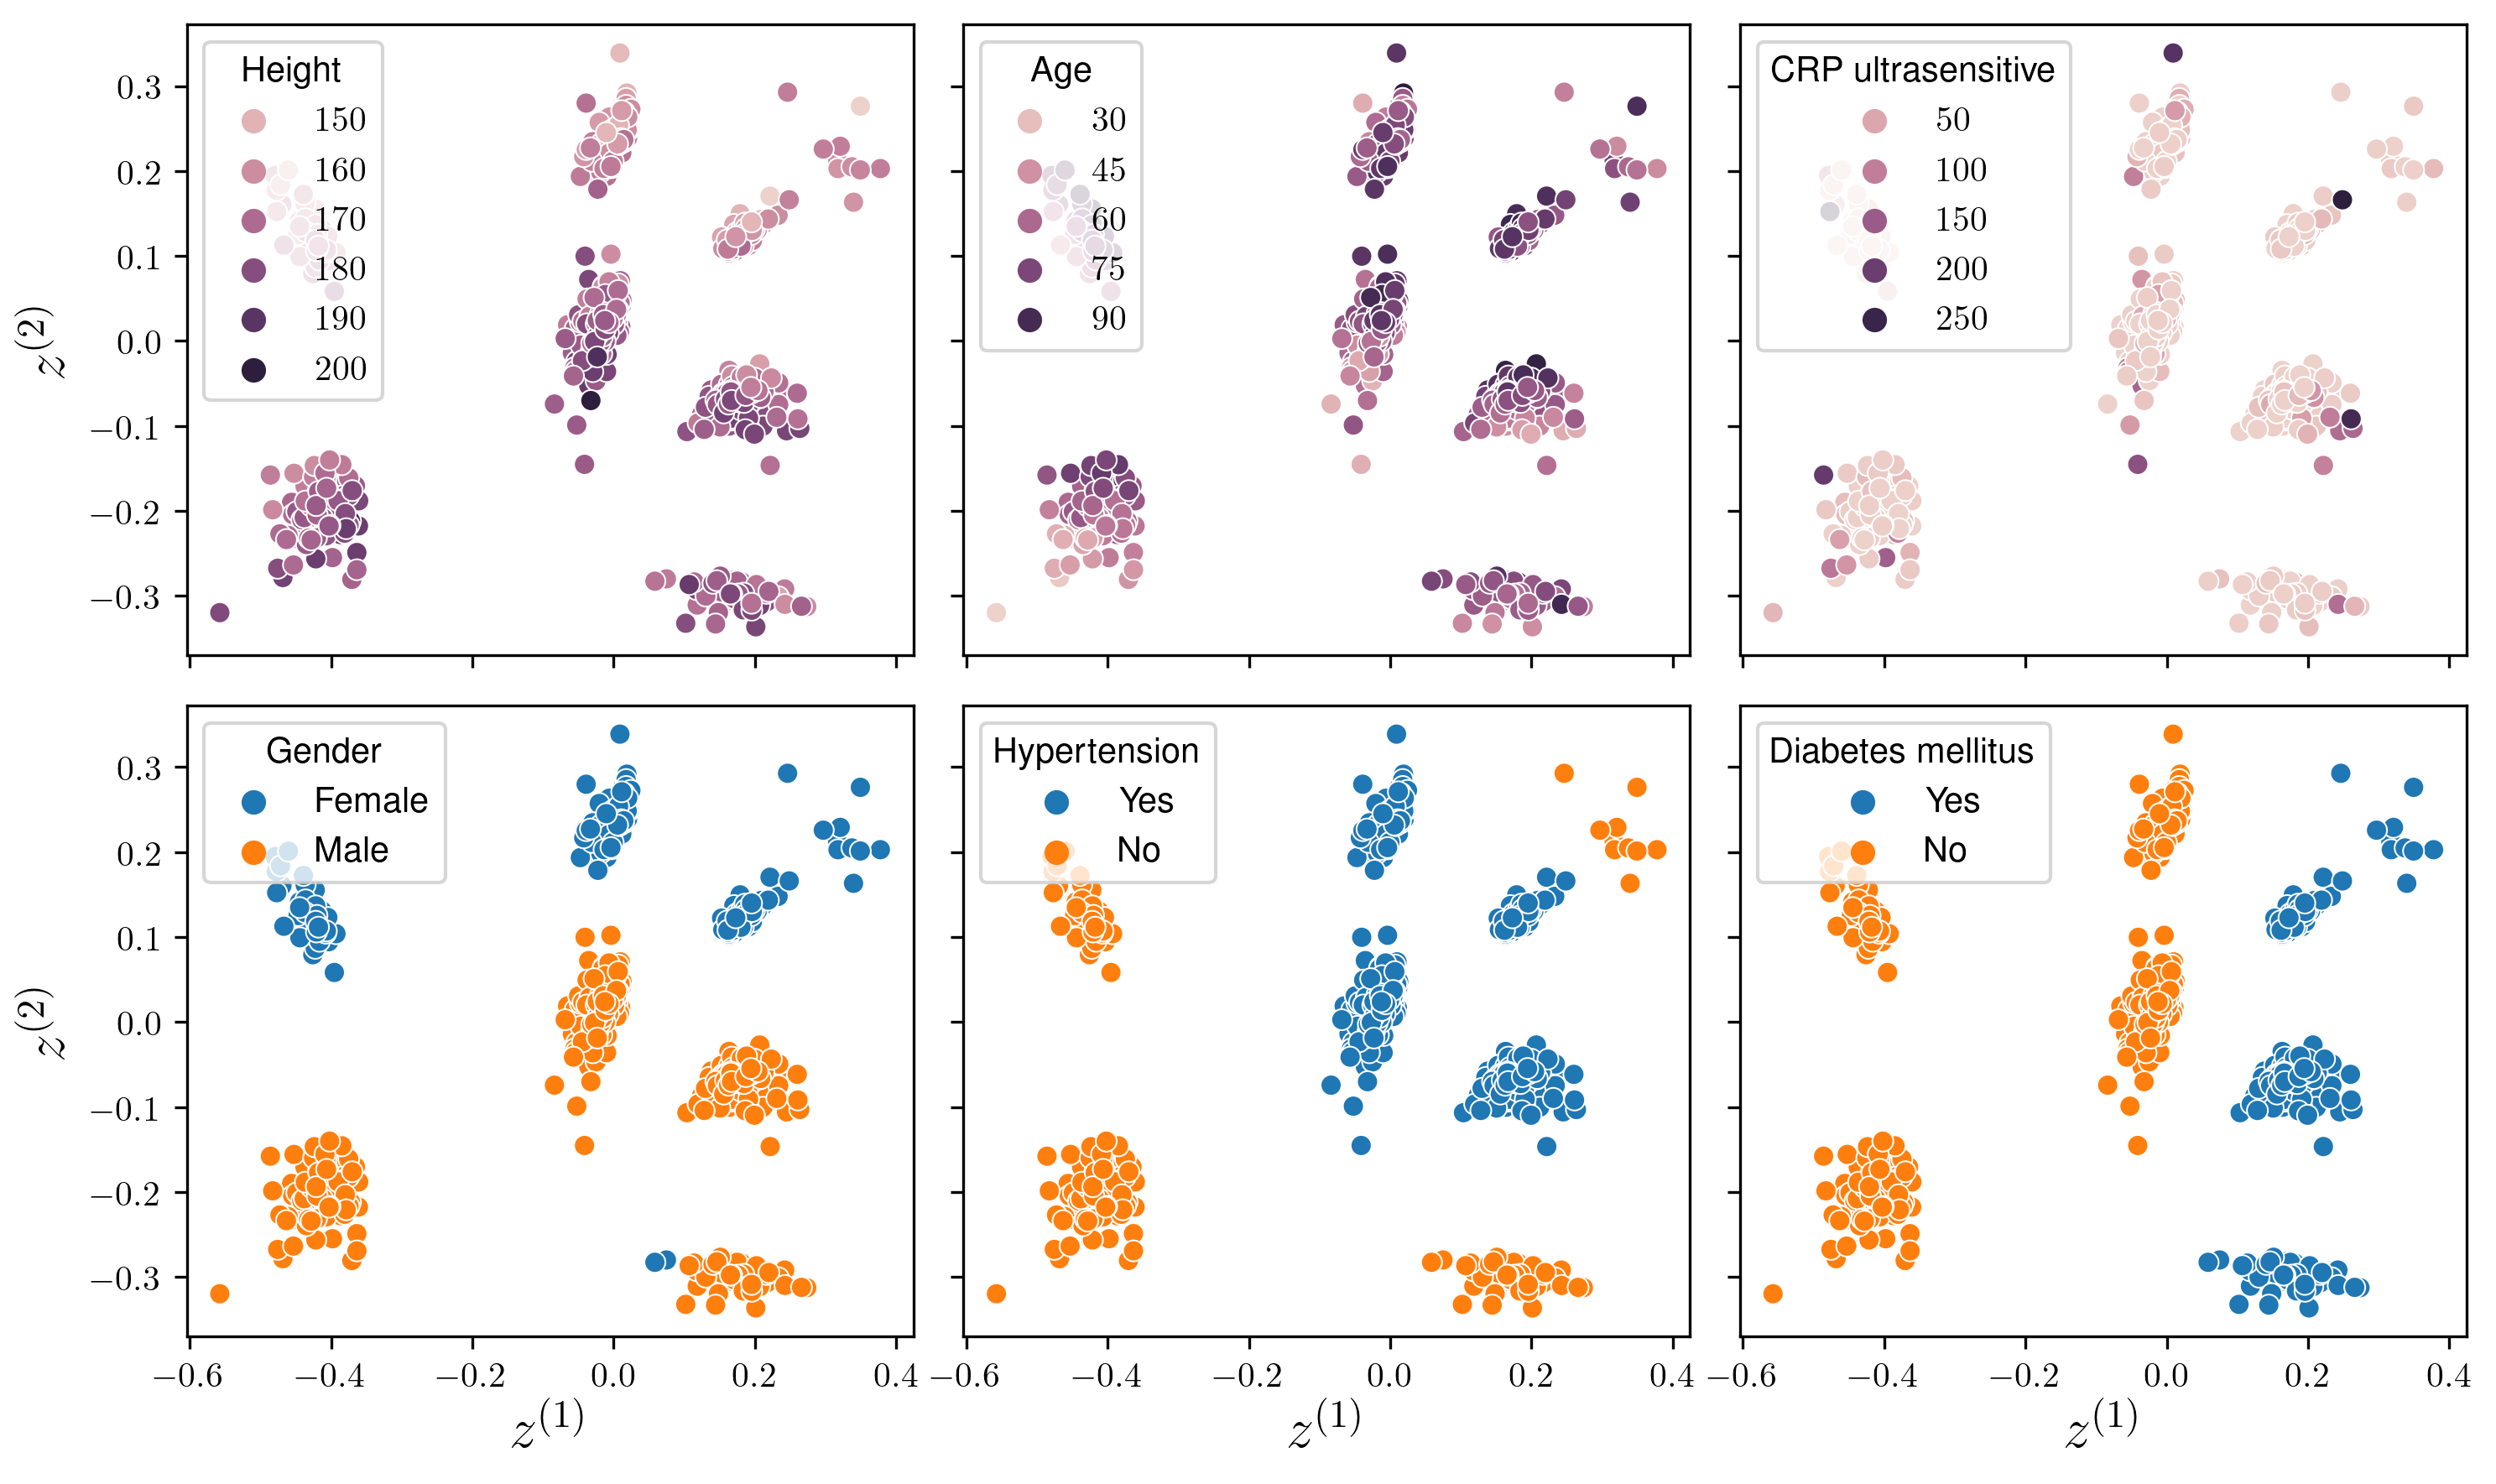

In [22]:
# columns_list = [
#     'Height', 'Weight', 'BMI',
#     'LDL cholesterol', 'HDL cholesterol', 'Total cholesterol', 
#     'CRP ultrasensitive', 'Age', 'Gender',
#     'Hypertension', 'Diabetes mellitus', 'Healthy'
# ]

columns_list = [
    'Height', 'Age',
    'CRP ultrasensitive', 'Gender',
    'Hypertension', 'Diabetes mellitus', 
]

fig, ax = plt.subplots(2,3, figsize=(10,6), sharex=True, sharey=True)
for col, axis in zip(columns_list, ax.flatten()):
    sns.scatterplot(
        ax=axis, data=df_dataset_latent,
        x='z1', y='z2',
        hue=df_dataset[col],
        legend=True
        )
    axis.set_xlabel(r'$z^{(1)}$', fontsize=16)
    axis.set_ylabel(r'$z^{(2)}$', fontsize=16)
    # sns.move_legend(
    #     axis, "lower center",
    #     bbox_to_anchor=(.5, 1), ncol=3, 
    #     )
    sns.move_legend(axis, "upper left")
    #axis.set_title(col)
fig.tight_layout()
plt.savefig(
        f'images/1_latent_space_data.png',
        dpi=300,
        facecolor='white',
        bbox_inches = 'tight'
    )
plt.show()

In [7]:
# with plt.style.context('fast'):
#     ax = sns.jointplot(x='z1', y='z2', data=df_dataset_latent, kind='kde', fill=False, alpha=0.7)
#     ax.ax_joint.set_xlabel(r'$z^{(1)}$', fontsize=16)
#     ax.ax_joint.set_ylabel(r'$z^{(2)}$', fontsize=16)
#     plt.show()

### Kernel Density Estimate of data in latent space

`dt_dataset_latent` $\rightarrow$ **KDE** $\rightarrow$ `df_samples_latent`

In [31]:
import joblib
from sklearn.neighbors import KernelDensity

# fit KDE to the dataset
kde = KernelDensity(kernel='gaussian', bandwidth=0.008).fit(df_dataset_latent)

joblib.dump(kde, 'kde.joblib');

# Generate random samples from the model
df_samples_latent = pd.DataFrame(kde.sample(len(df_dataset_scaled)), columns=df_dataset_latent.columns)

#### Draw KDE contour plot with latent space data

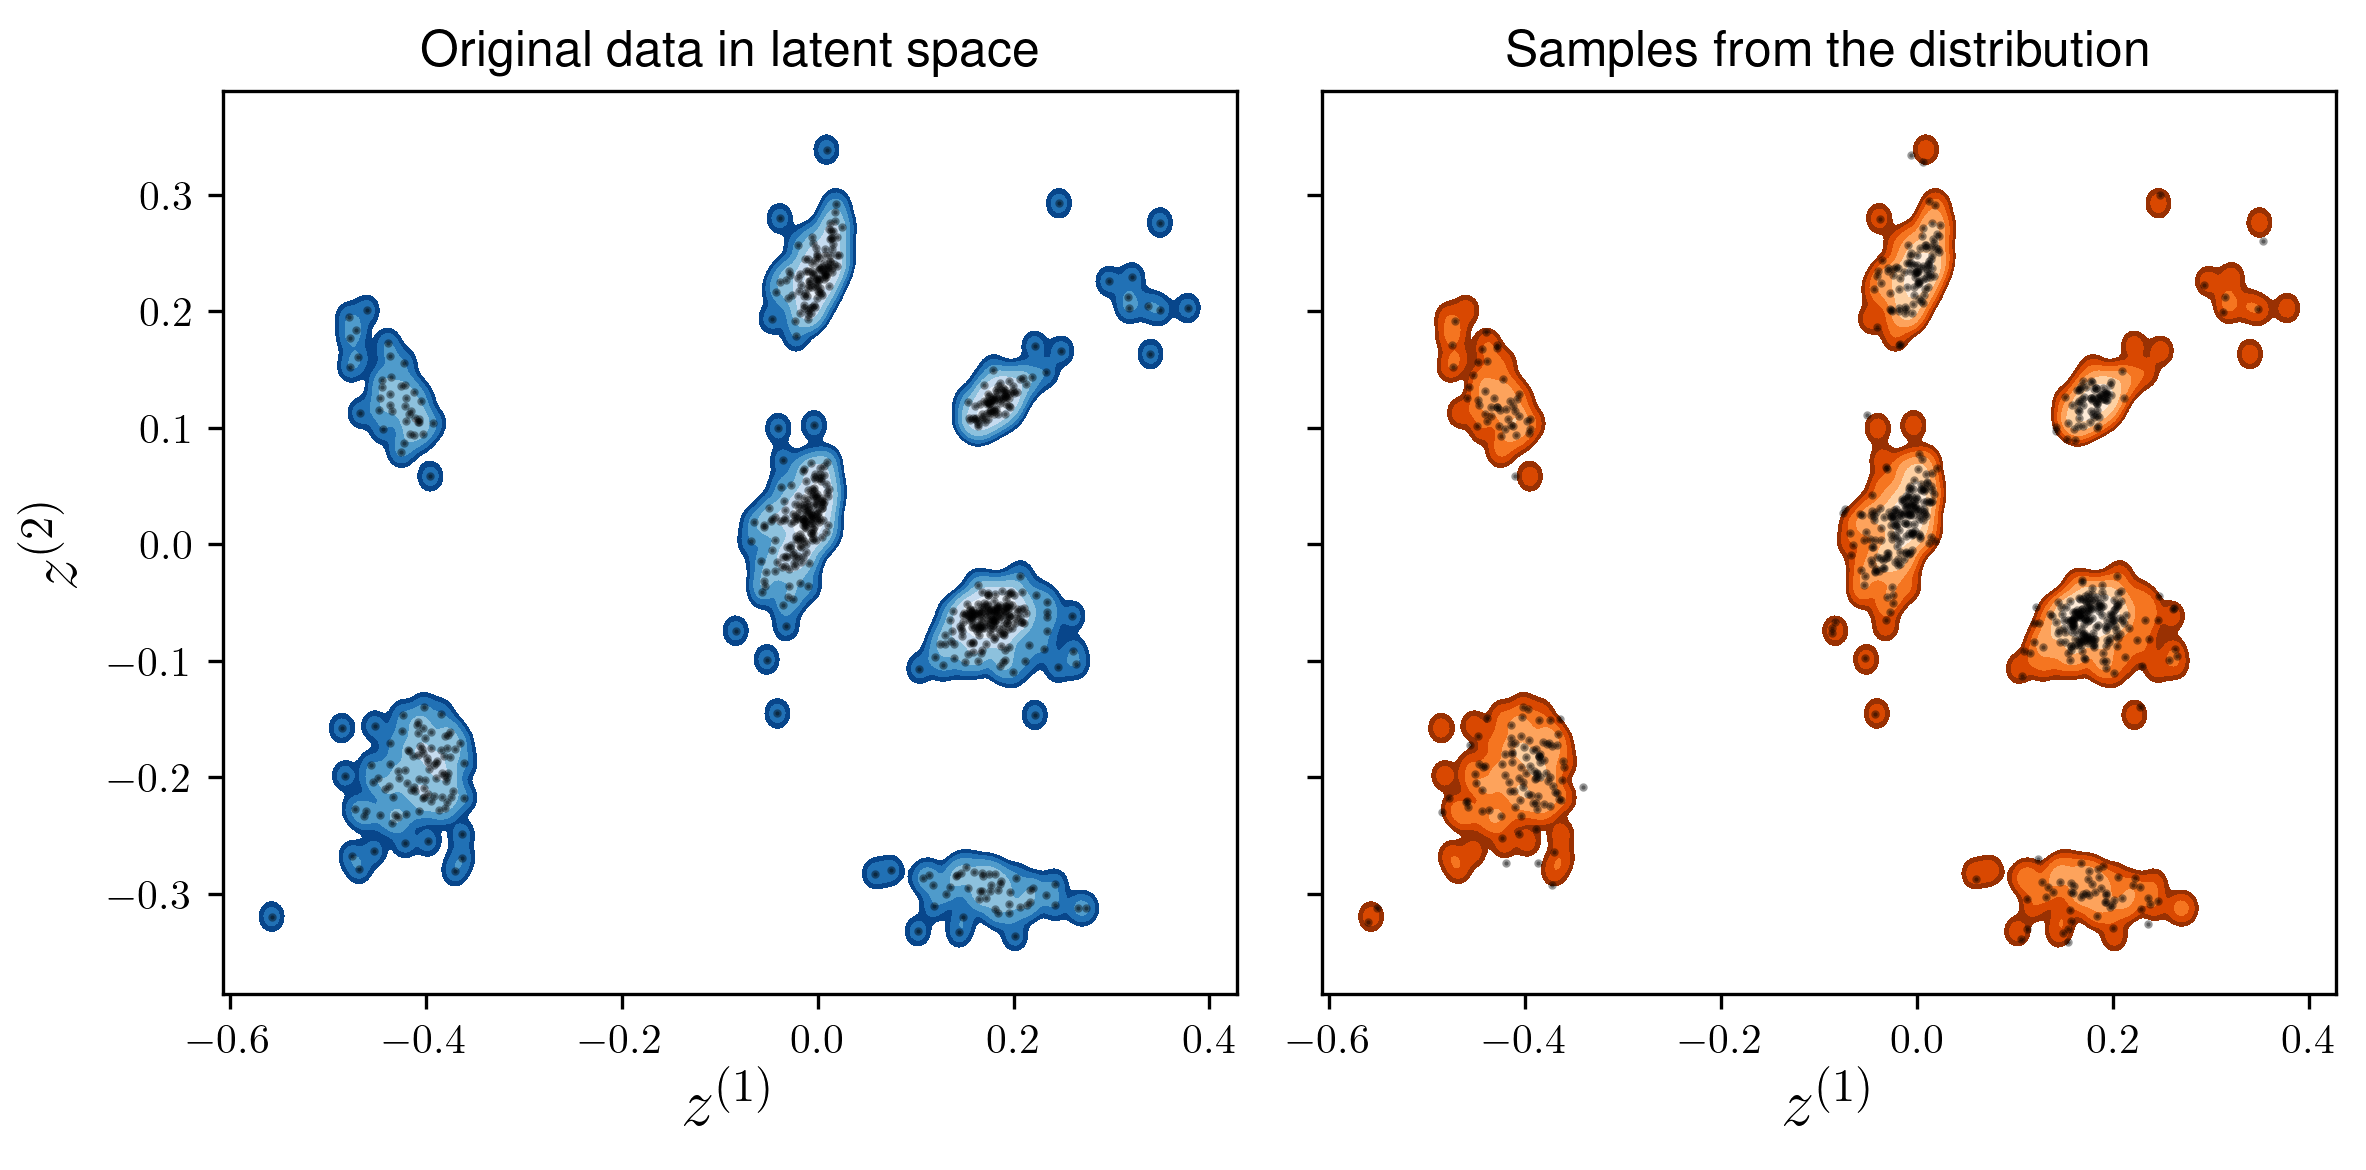

In [32]:
z1_range = np.linspace(df_dataset_latent['z1'].min()-0.05, df_dataset_latent['z1'].max()+0.05, 300)
z2_range = np.linspace(df_dataset_latent['z2'].min()-0.05, df_dataset_latent['z2'].max()+0.05, 300)
z1_grid, z2_grid = np.meshgrid(z1_range, z2_range)

density = np.exp(kde.score_samples(pd.DataFrame(zip(z1_grid.flatten(), z2_grid.flatten()),
                                                columns=df_dataset_latent.columns))).reshape(z1_grid.shape)

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

ax[0].contourf(z1_grid, z2_grid, density, norm=LogNorm(vmin=1.0, vmax=100.0), levels=np.logspace(0, 3, 10), cmap='Blues_r')
ax[0].scatter(df_dataset_latent['z1'], df_dataset_latent['z2'], s=1, color='black', alpha=0.4)
ax[0].set_title('Original data in latent space')
ax[0].set_xlabel(r'$z^{(1)}$', fontsize=16)
ax[0].set_ylabel(r'$z^{(2)}$', fontsize=16)

ax[1].contourf(z1_grid, z2_grid, density, norm=LogNorm(vmin=1.0, vmax=100.0), levels=np.logspace(0, 3, 10), cmap='Oranges_r')
ax[1].scatter(df_samples_latent['z1'], df_samples_latent['z2'], s=1, color='black', alpha=0.4)
ax[1].set_title('Samples from the distribution')
ax[1].set_xlabel(r'$z^{(1)}$', fontsize=16)
fig.tight_layout()
#fig.suptitle('Kernel Density Estimator')
plt.savefig(
        f'images/2_kde.png',
        dpi=300,
        facecolor='white',
        bbox_inches = 'tight'
    )
plt.show()

### Learn decoders from latent space to original space

(`dt_dataset_latent`, `df_scaled[column]`) $\rightarrow$ **`decoders[column]`**

In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor


def make_decoder(model, features, target, display=None):
    
    (features_train, features_test,
     target_train, target_test) = train_test_split(features, target, test_size=0.1)

    model.fit(features_train, target_train)
    
    if display == 'cont':
        pred_train = model.predict(features_train)
        pred_test = model.predict(features_test)

        fig, ax = plt.subplots(1,2, figsize=(6,3), sharey=True)
        ax[0].scatter(target_train, pred_train, alpha=0.5, s=8, label='training data')
        ax[0].axis('square')
        ax[0].plot([0, 1], [0, 1], color='black', label='ideal')
        ax[0].set_xlim([0,1])
        ax[0].set_ylim([0,1])
        ax[0].set_xlabel('target')
        ax[0].set_ylabel('prediction')
        ax[0].legend()
        ax[1].scatter(target_test, pred_test, alpha=0.5, s=8, label='testing data')
        ax[1].axis('square')
        ax[1].plot([0, 1], [0, 1], color='black', label='ideal')
        ax[1].set_xlim([0,1])
        ax[1].set_ylim([0,1])
        ax[1].set_xlabel('target')
        fig.suptitle(target.name)
        ax[1].legend()
        plt.savefig(
            f'images/3_{target.name}.png',
            dpi=300,
            facecolor='white',
            bbox_inches = 'tight'
    )
        plt.show()
        
    elif display == 'cat':
        pred_train = model.predict(features_train)
        pred_test = model.predict(features_test)

        fig, ax = plt.subplots(1,1)
        cm = confusion_matrix(target_test, pred_test, labels=np.unique(target_test))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=np.unique(target_test))
        ax.set_title(target.name)
        disp.plot(ax=ax);
    
    return model


def make_decoders(df_latent, df_target, cont_columns, cat_columns, display=False):
    """
    display: {None, 'cont', 'cat'}, default=None
    """

    decoders = {}

    for col in cont_columns:
        decoders[col] = make_decoder(
            model=RandomForestRegressor(),
            features=df_latent,
            target=df_target[col],
            display='cont' if display else None
            )
        
    for col in cat_columns:
        decoders[col] = make_decoder(
            model=SVC(),
            features=df_latent,
            target=df_target[col],
            display='cat' if display else None
            )
    
    return decoders

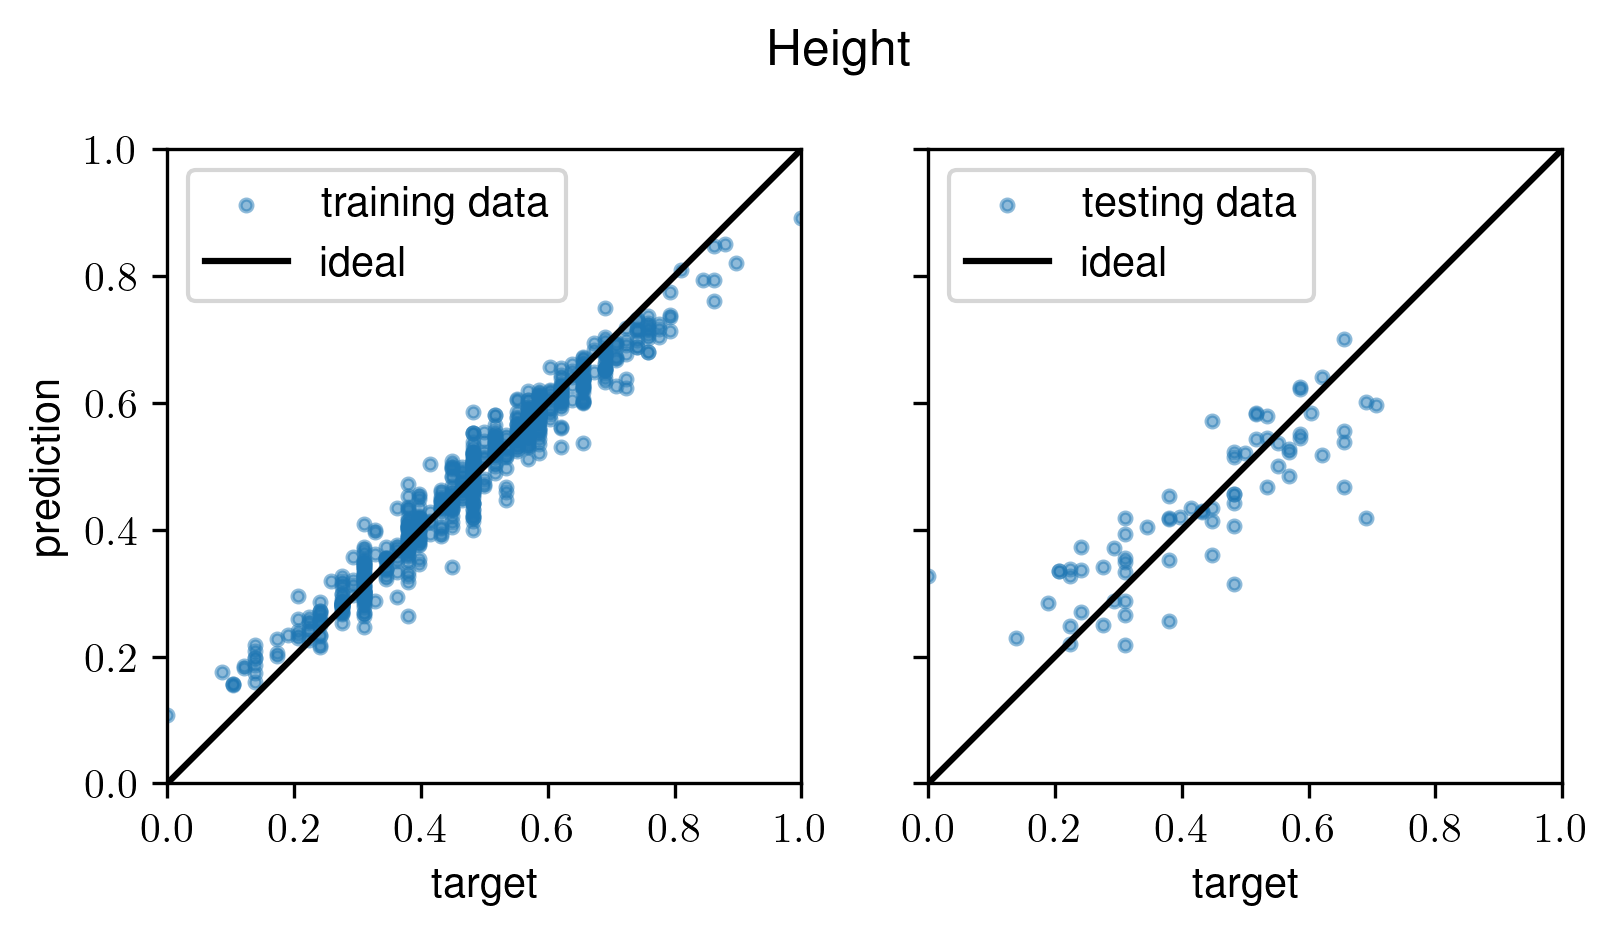

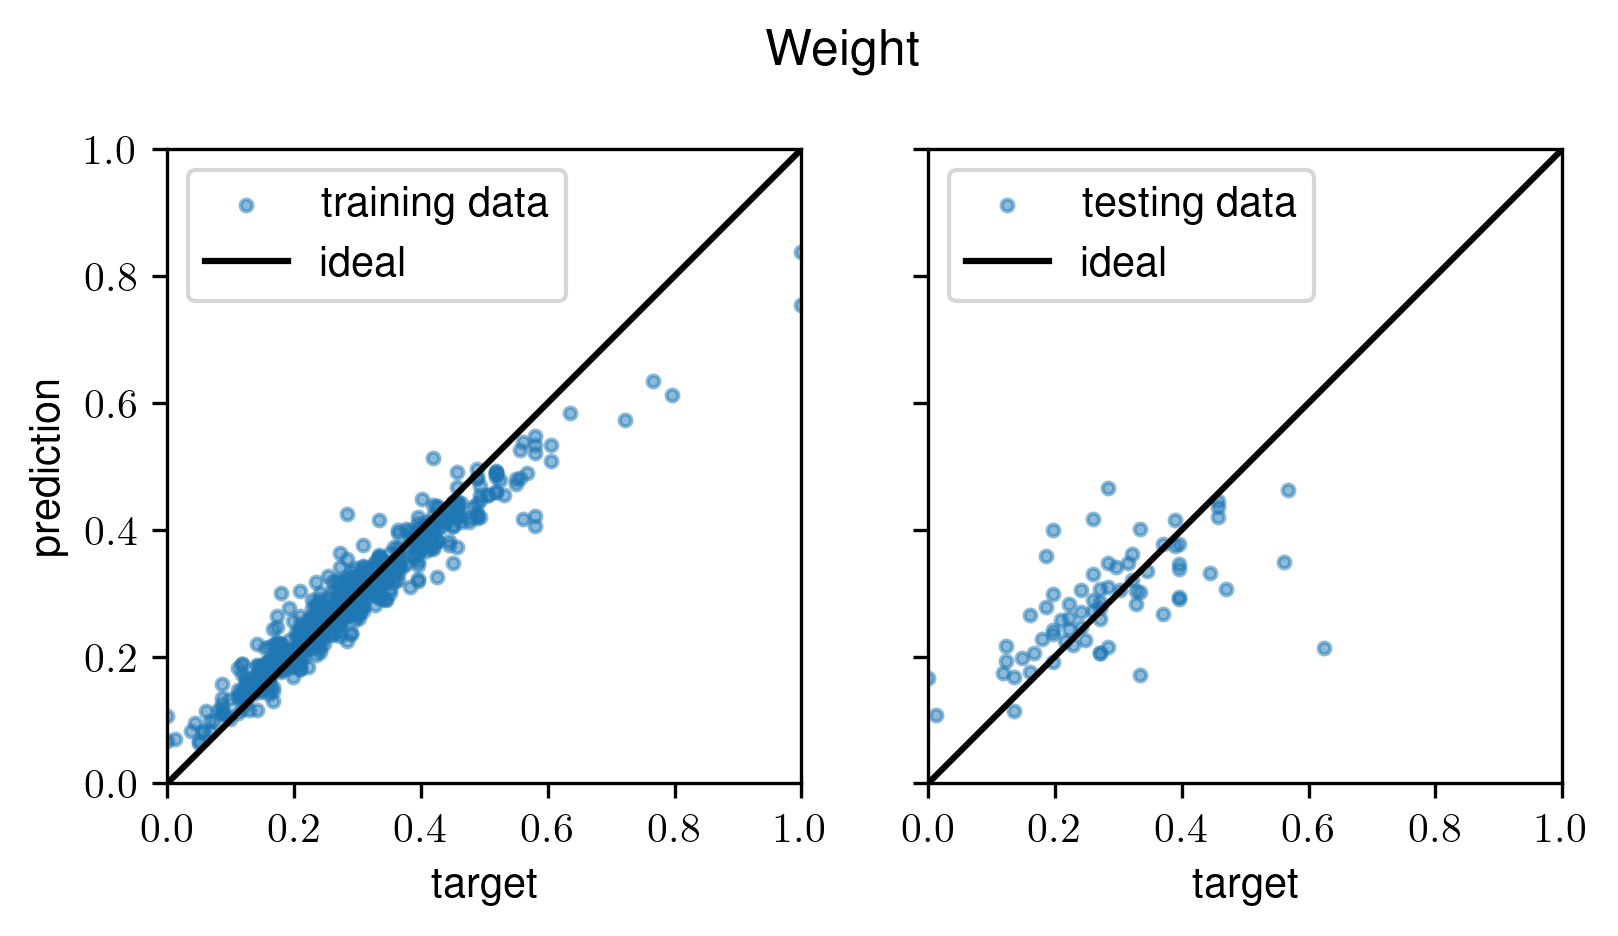

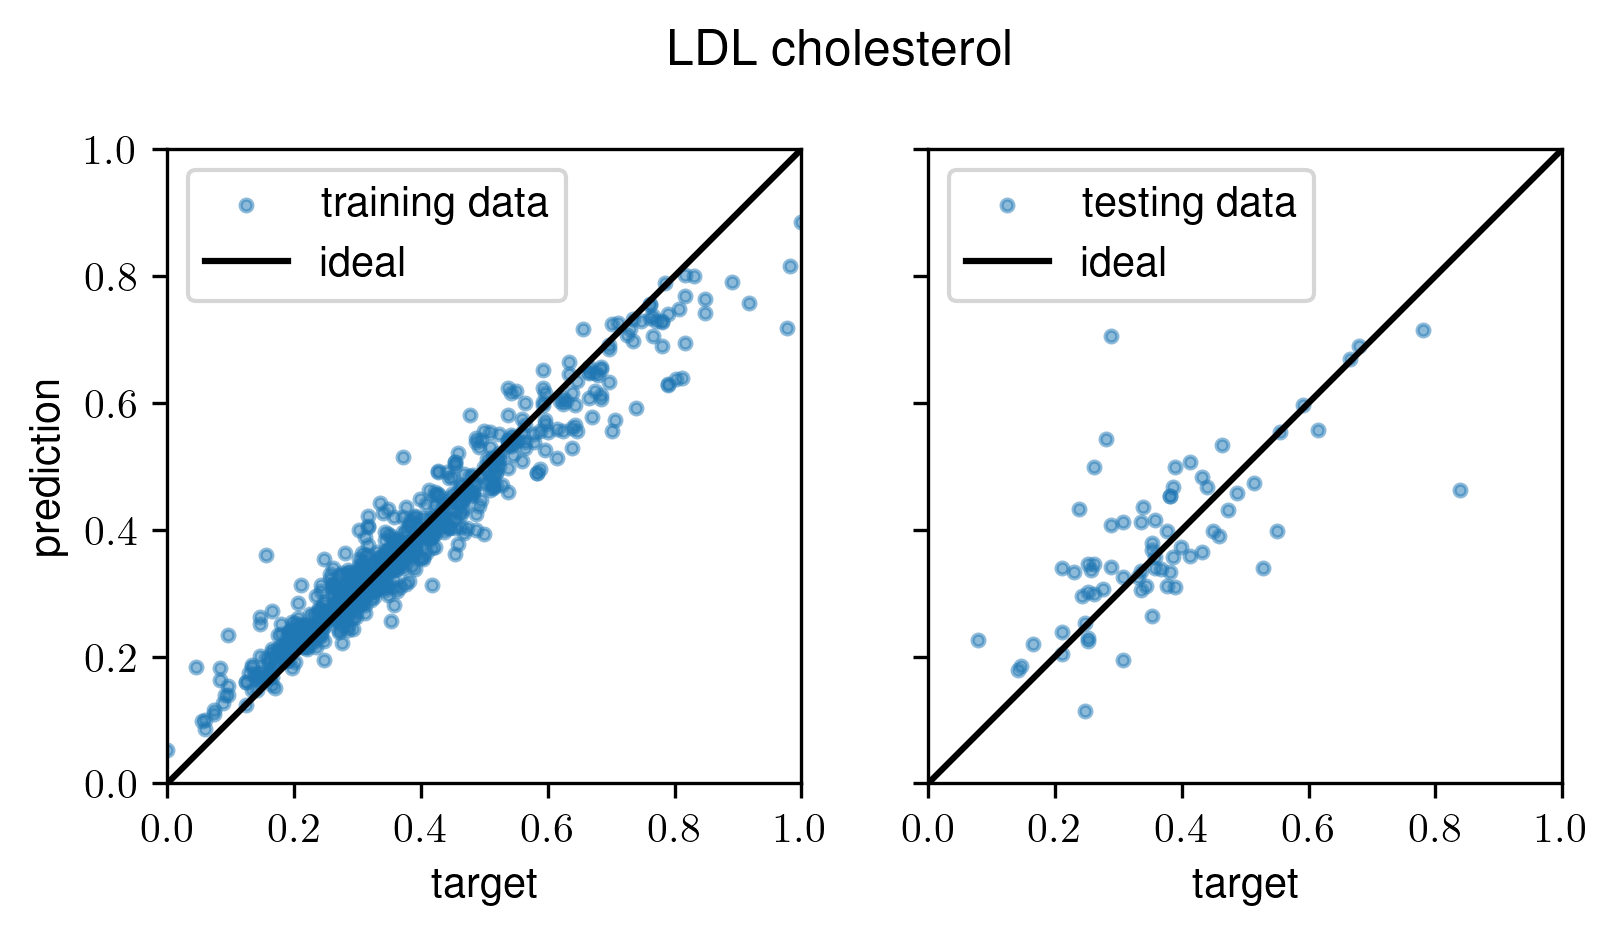

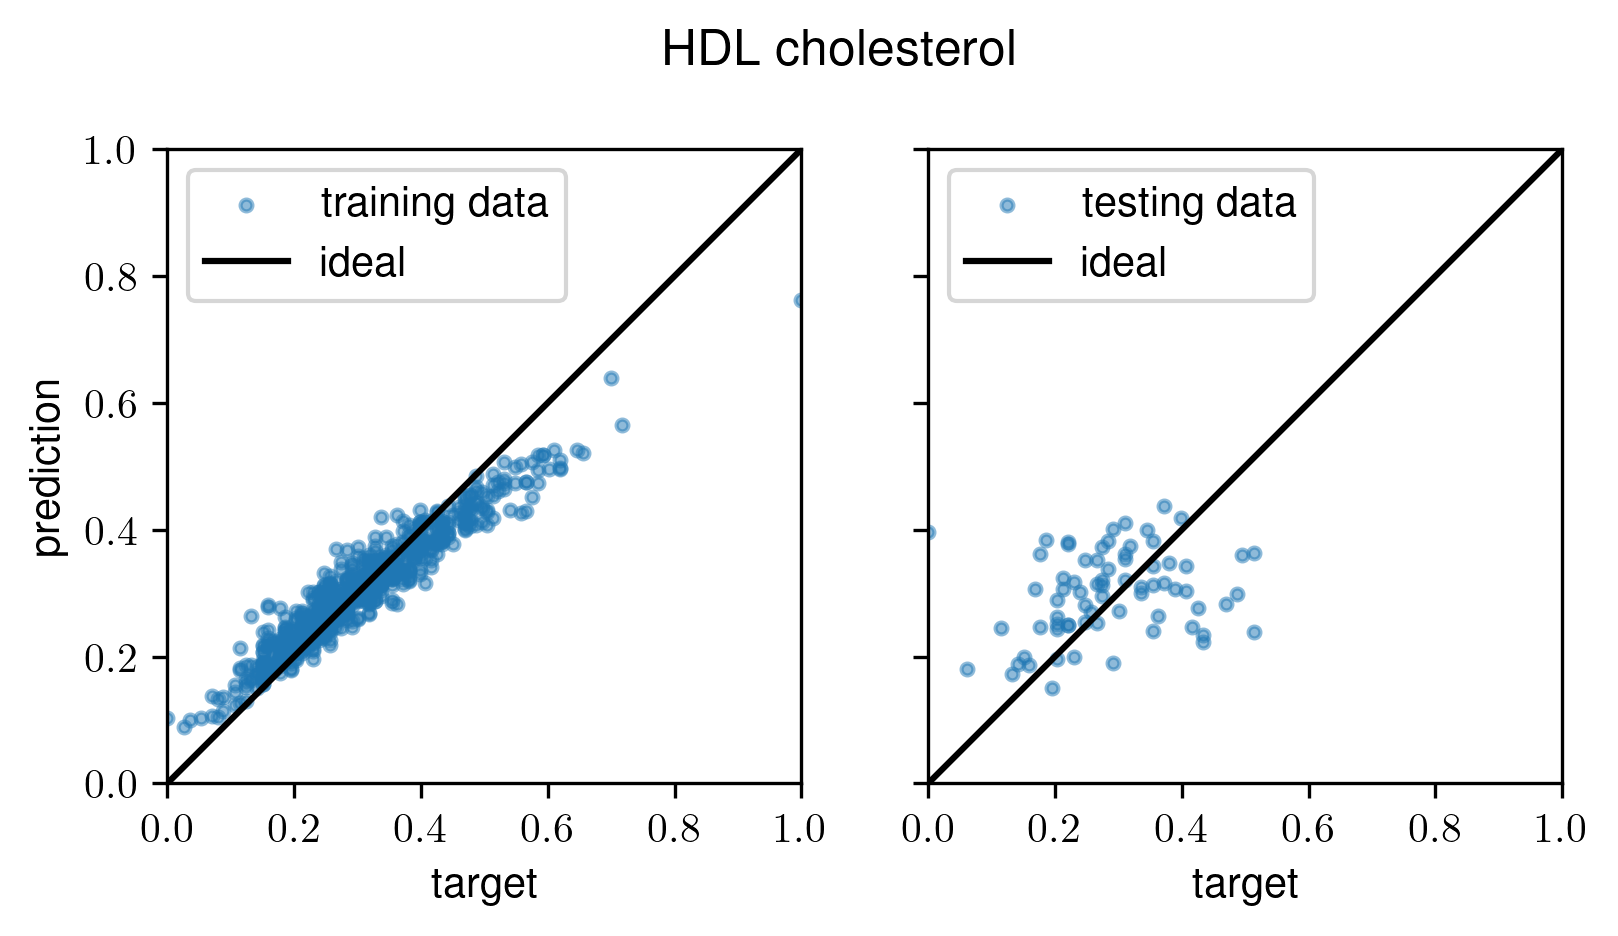

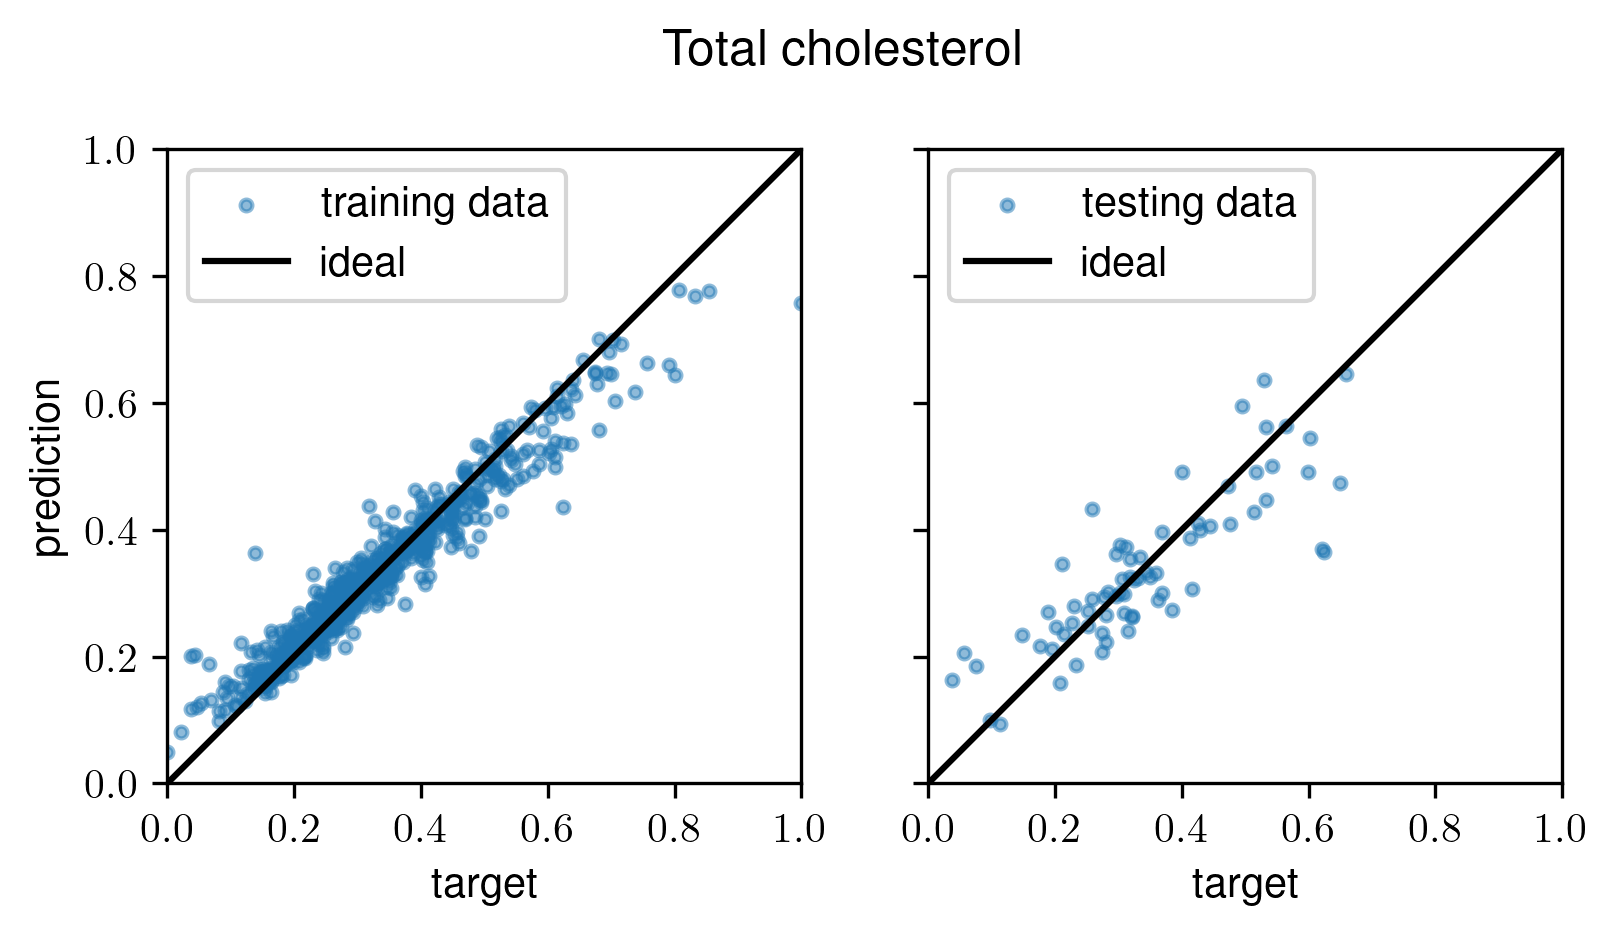

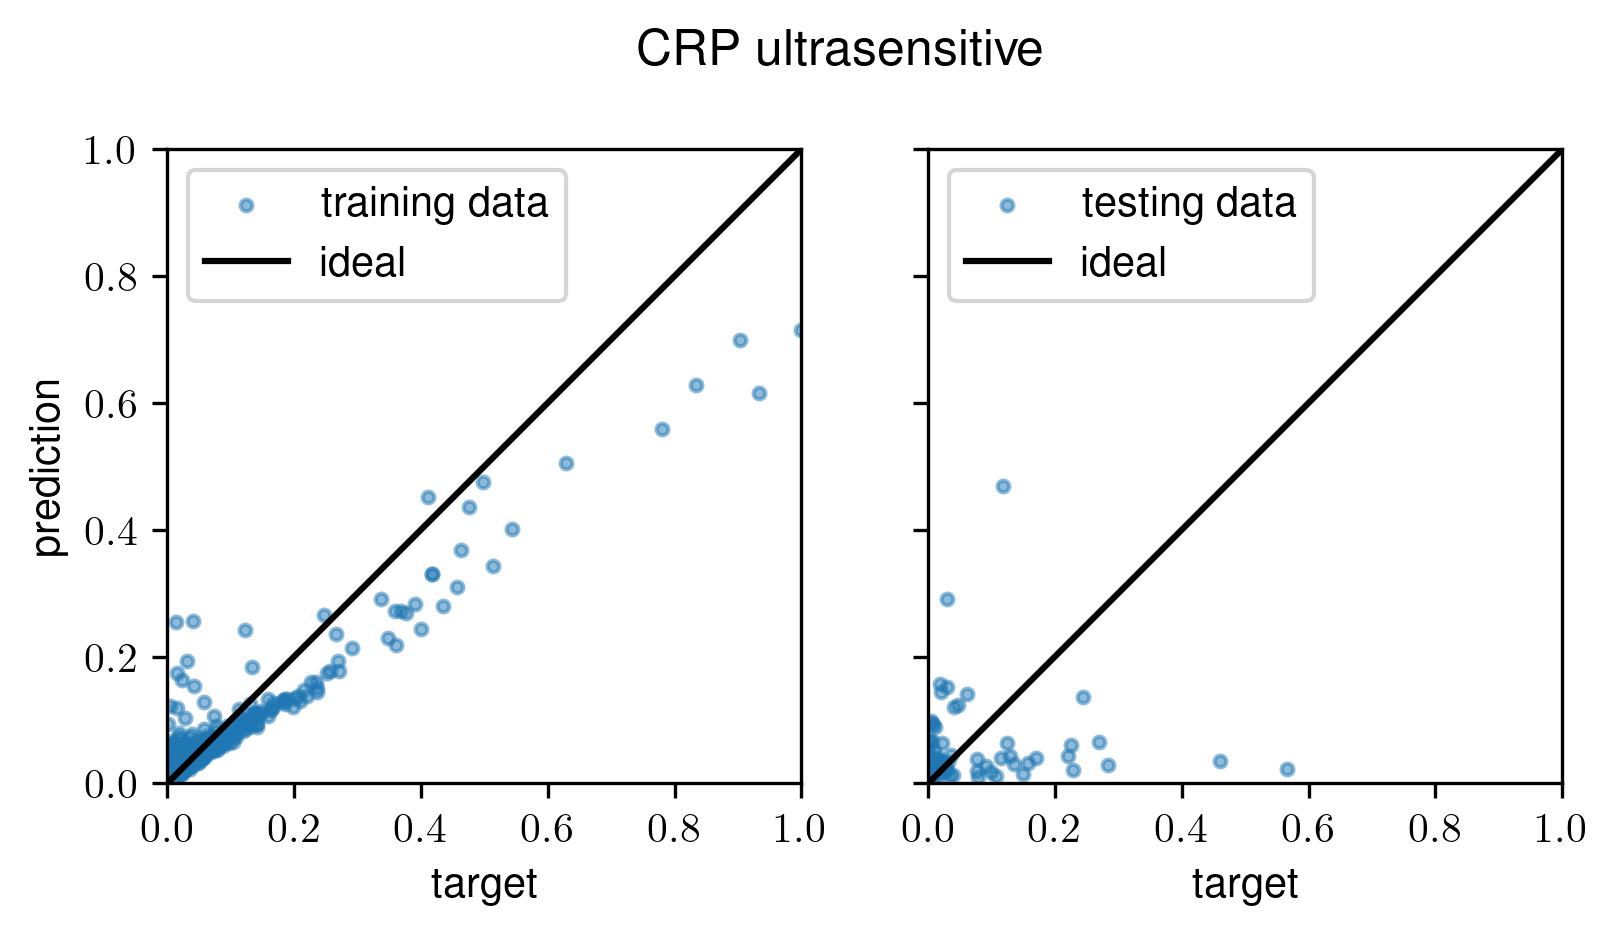

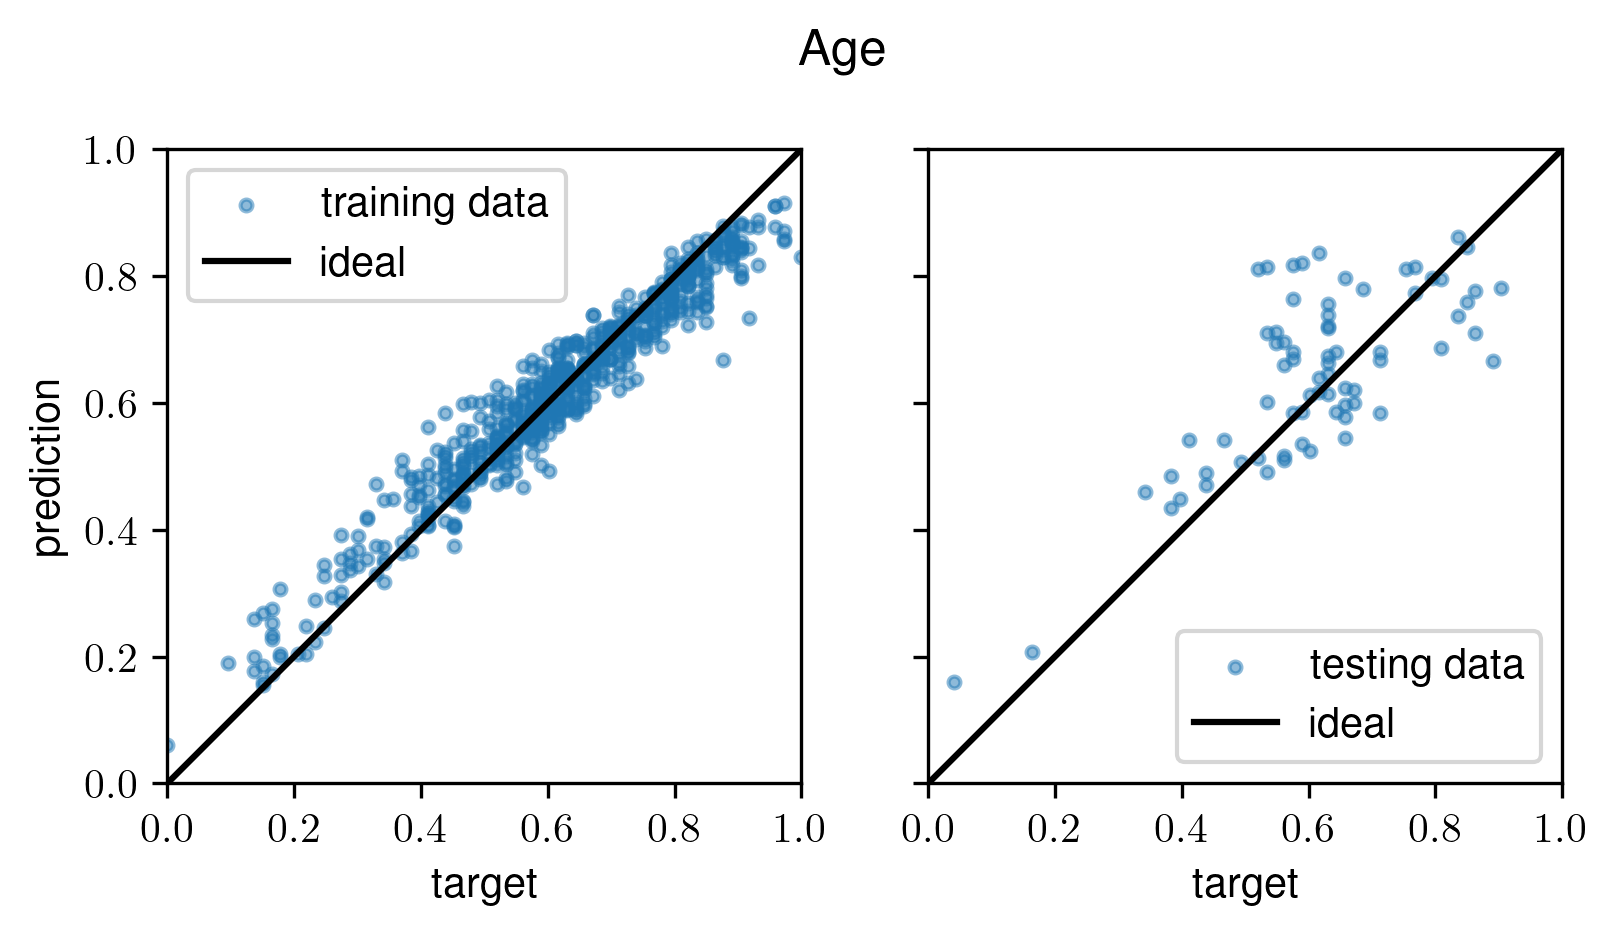

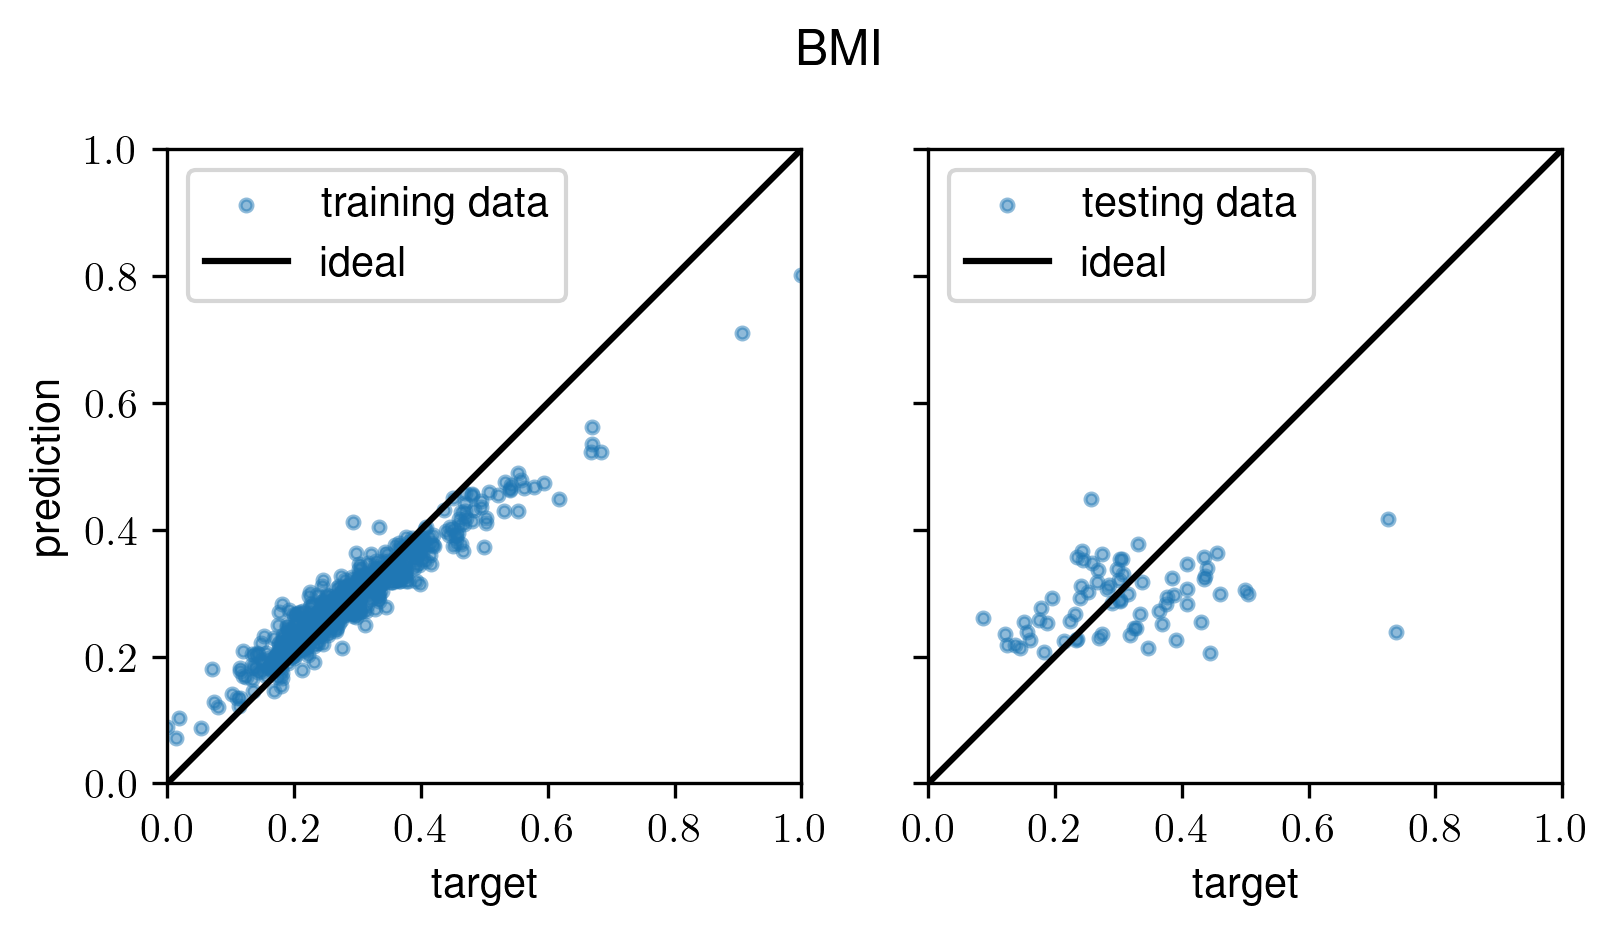

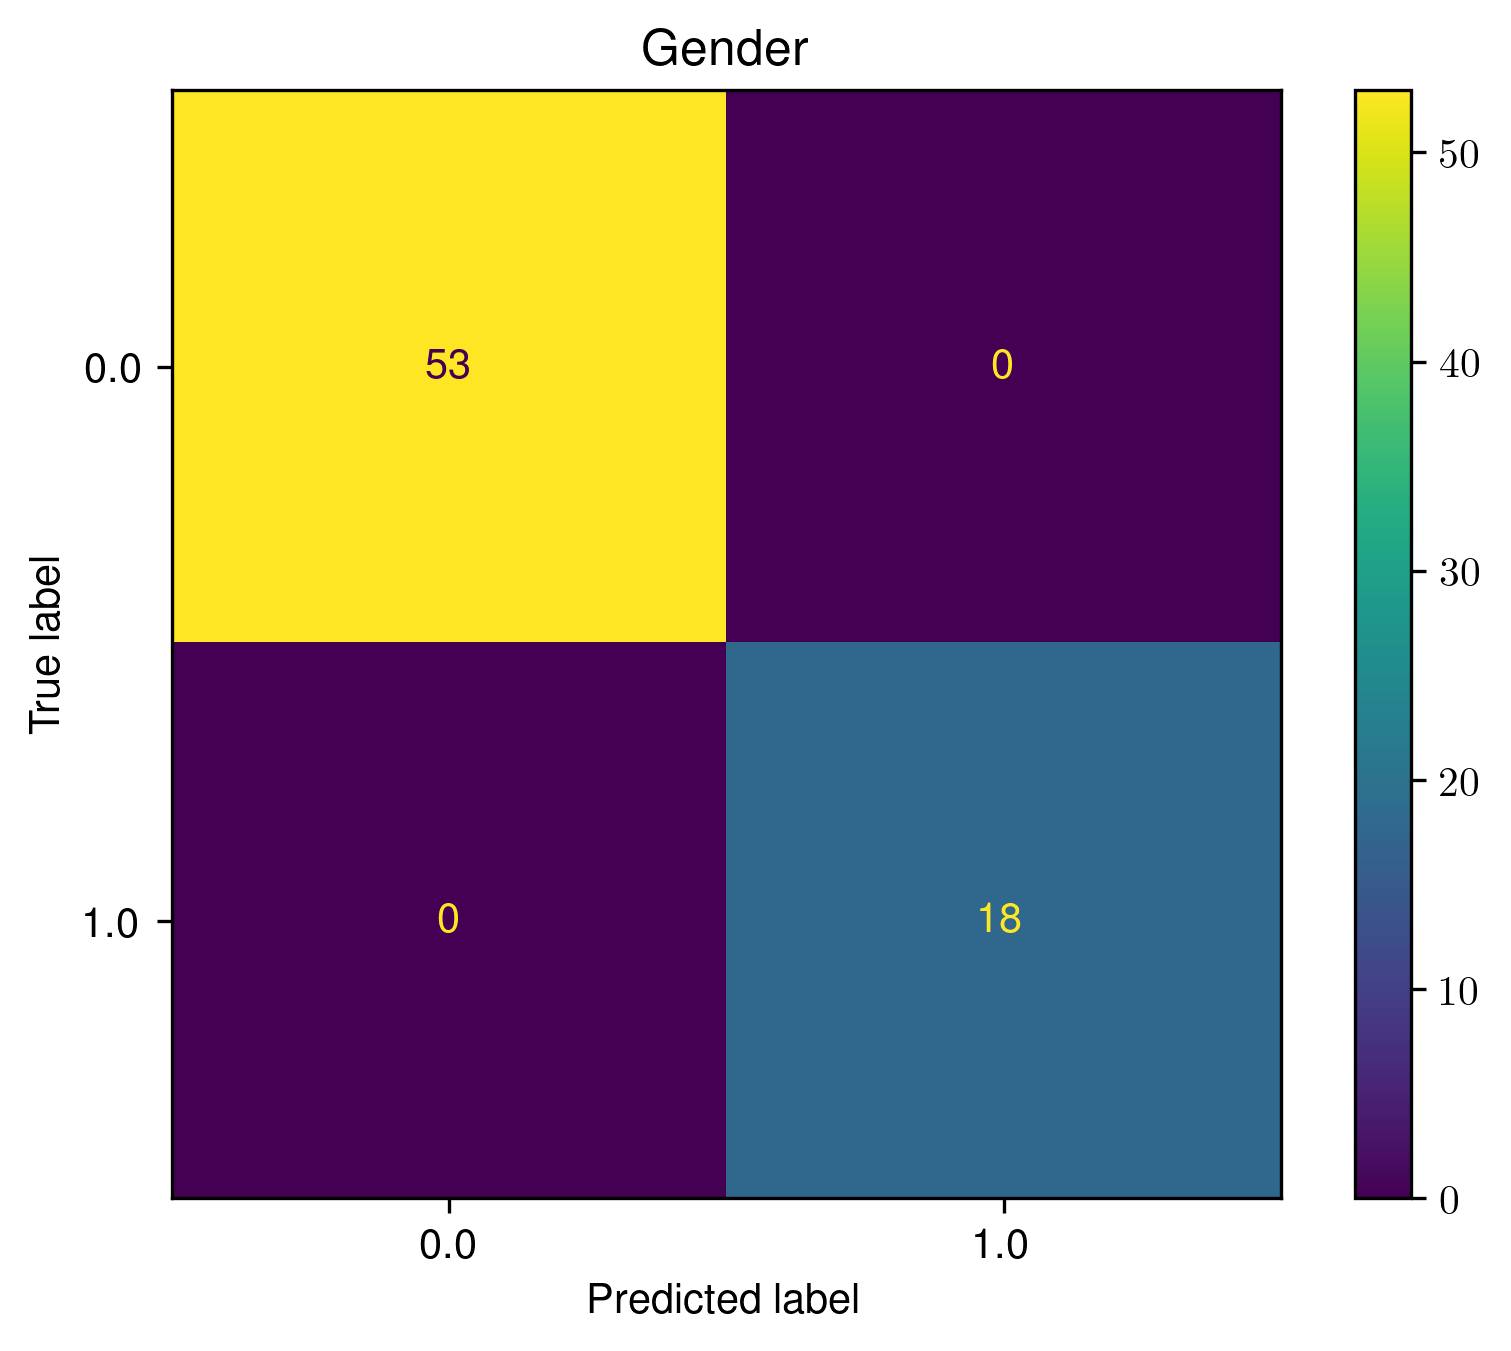

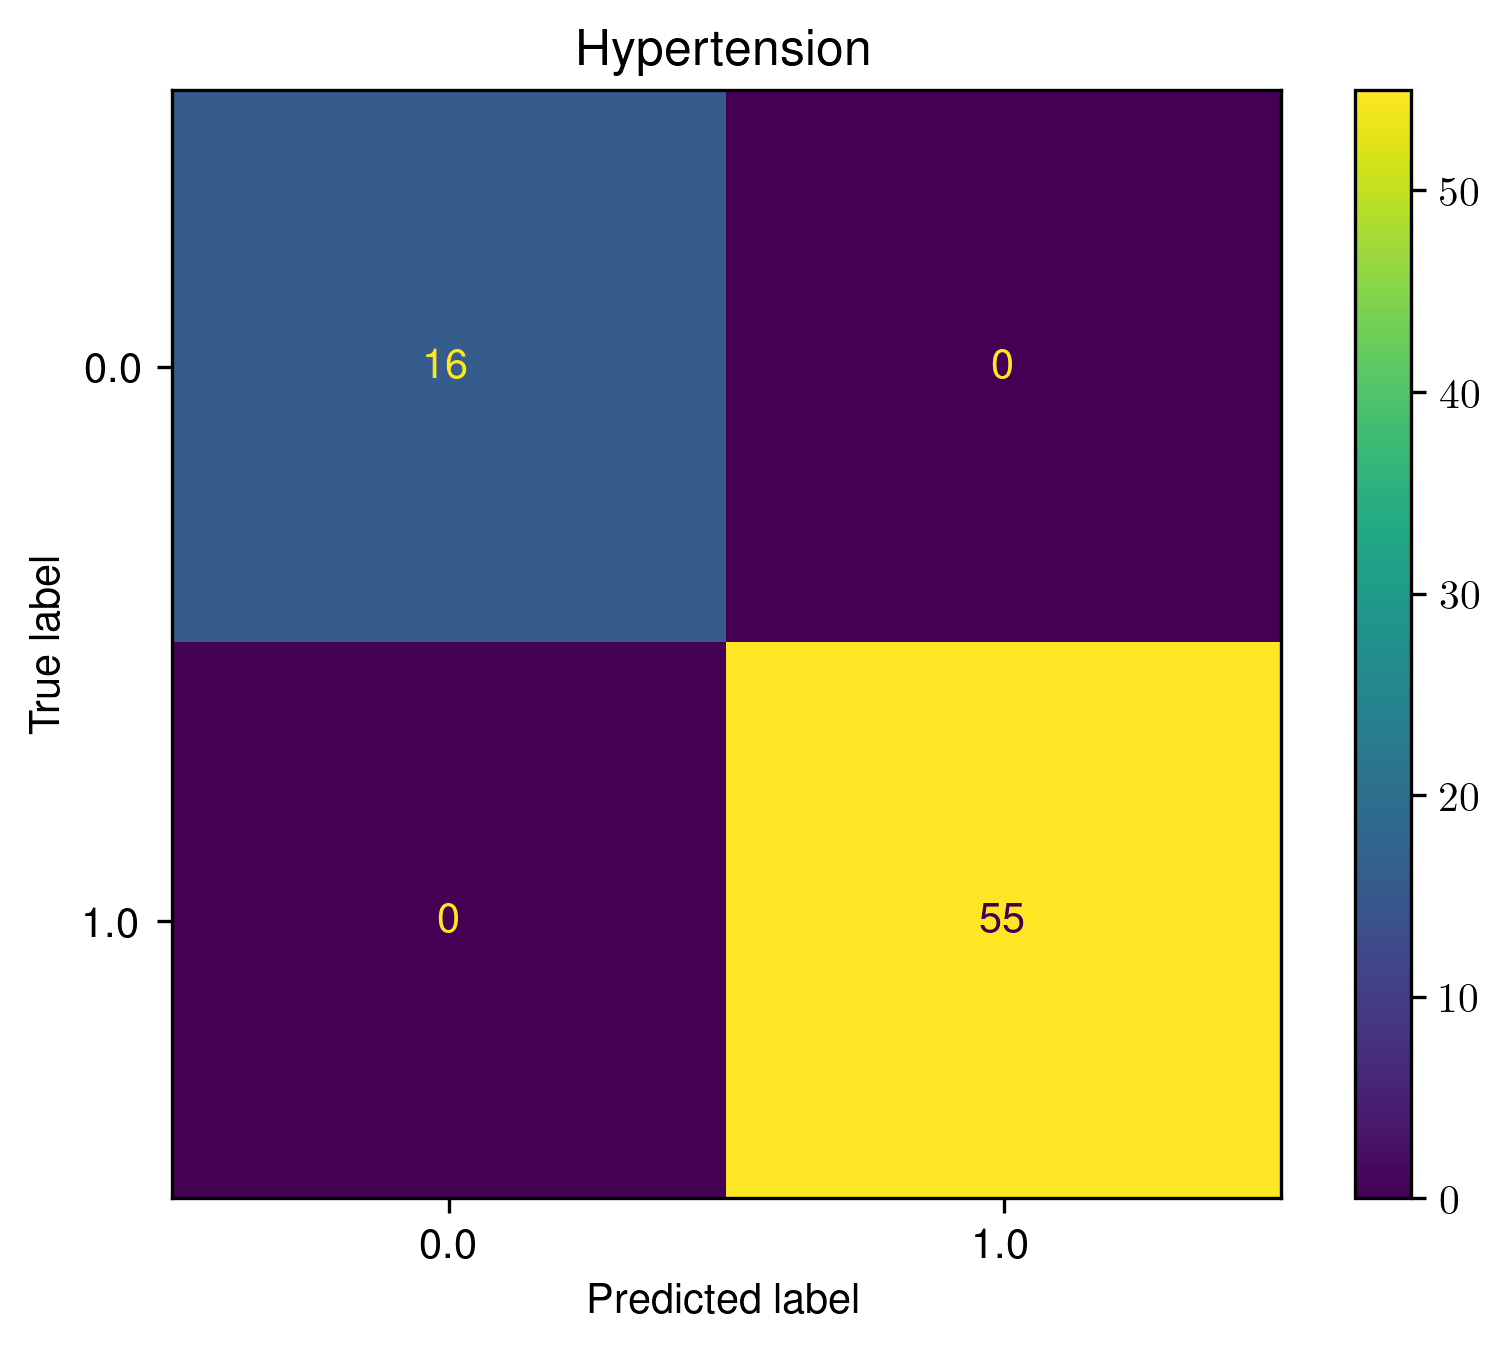

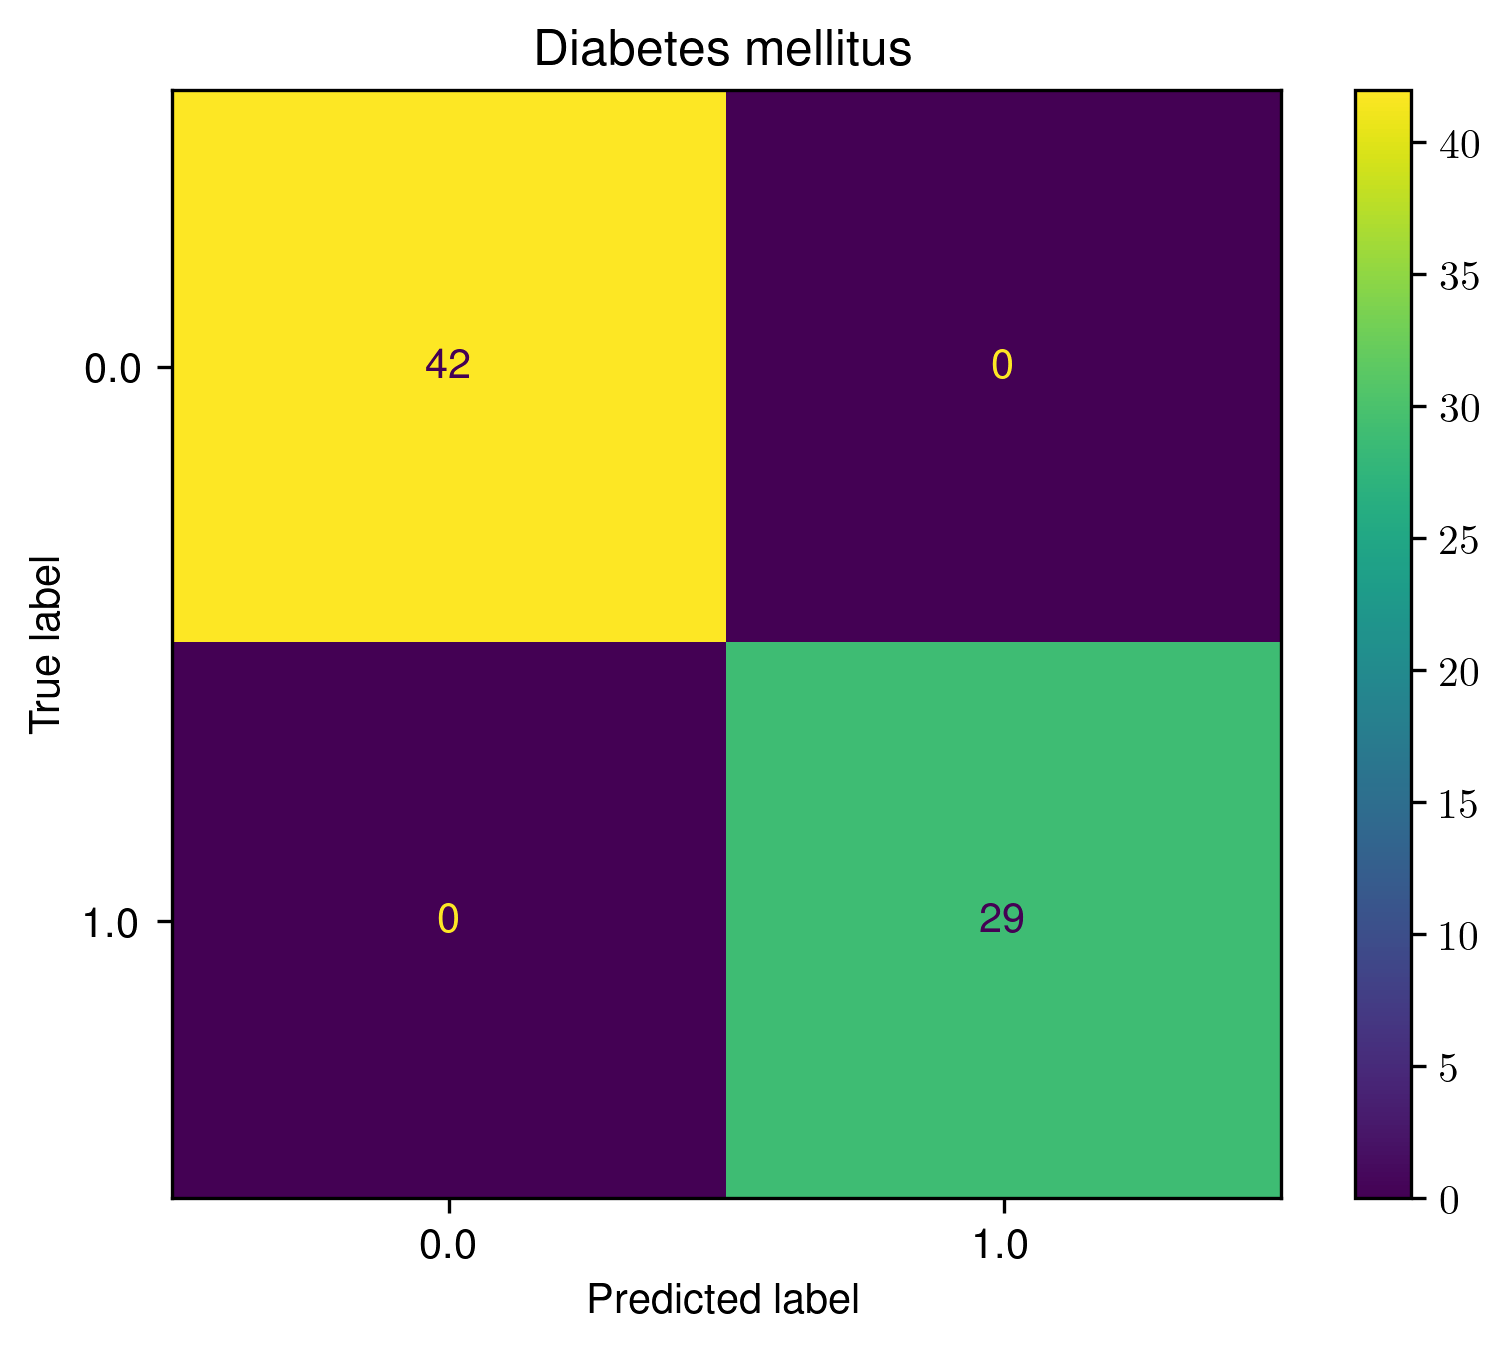

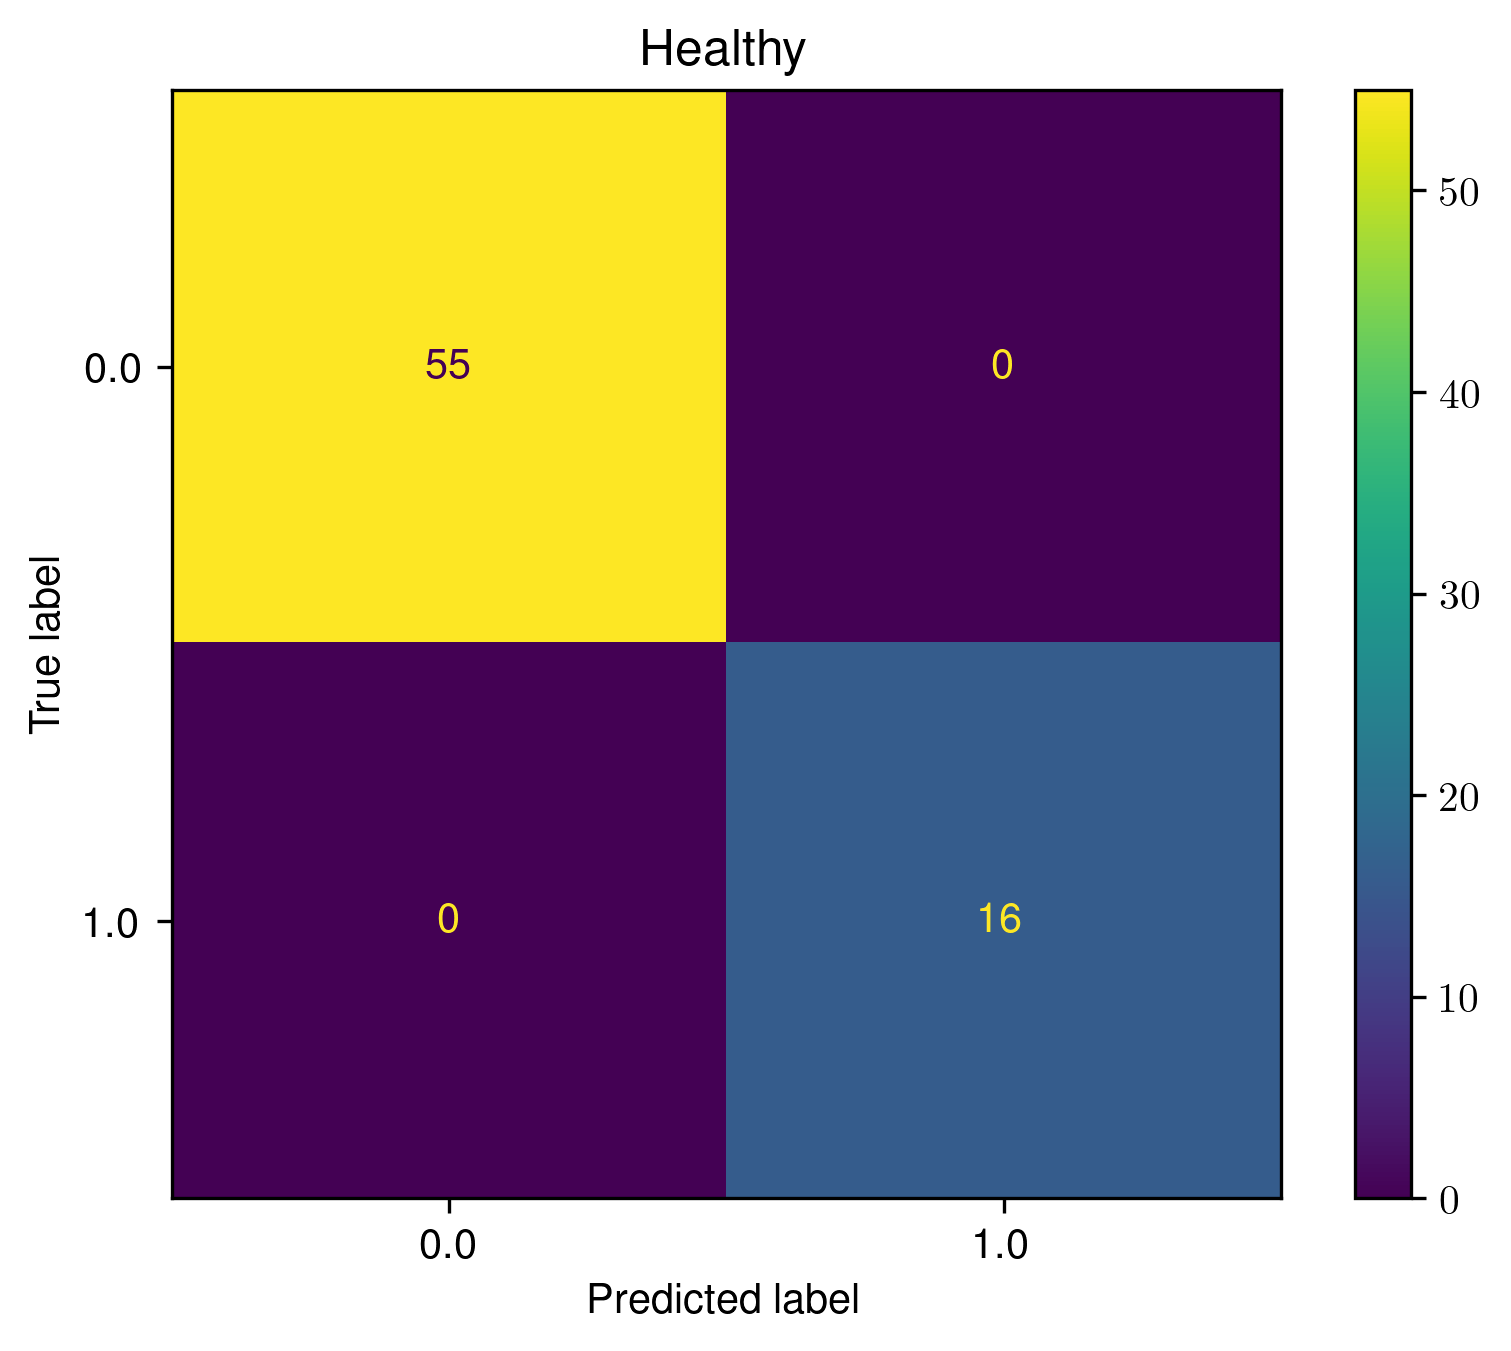

In [34]:
decoders = make_decoders(
    df_latent=df_dataset_latent, 
    df_target=df_dataset_scaled, 
    cont_columns=['Height', 'Weight',
                  'LDL cholesterol', 'HDL cholesterol', 'Total cholesterol',
                  'CRP ultrasensitive', 'Age', 'BMI'], 
    cat_columns=['Gender', 'Hypertension', 'Diabetes mellitus', 'Healthy'],
    display=True
)

### Decode samples from latent space to original space

`df_samples_latent` $\rightarrow$ **`decoders`** $\rightarrow$ `df_synthetic_num` $\rightarrow$ `df_synthetic`

In [35]:
def df_to_rows(df):
    return [pd.DataFrame(row).T for index, row in df.iterrows()]

def decode_sample(sample):
    return {col: decoder.predict(sample)[0] for col, decoder in decoders.items()}

samples_latent = df_to_rows(df_samples_latent)
df_decoded_samples = pd.DataFrame([decode_sample(sample) for sample in samples_latent], columns=df_dataset.columns)

df_synthetic_raw = back_to_original_scale(df_decoded_samples, scaler)

In [36]:
def round_to_2sd(df, columns):

    df_new = df.copy()
    for col in columns:
        df_new[col] = df_new[col].apply(lambda value: round(value, 2))
    
    return df_new


def round_to_1sd(df, columns):

    df_new = df.copy()
    for col in columns:
        df_new[col] = df_new[col].apply(lambda value: round(value, 1))
    
    return df_new


df_synthetic_num = (
    df_synthetic_raw.
    pipe(round_to_2sd, columns=['CRP ultrasensitive']).
    pipe(round_to_1sd, columns=['BMI']).
    pipe(to_int, columns=[
        'Height', 'Weight',
        'LDL cholesterol', 'HDL cholesterol', 'Total cholesterol',
        'Age', 
        'Gender', 'Hypertension', 'Diabetes mellitus', 'Healthy'])
)

df_synthetic = (
    df_synthetic_num.
    pipe(map_values, columns_mappings={
        'Gender': {1: 'Female', 0: 'Male'},
        'Hypertension': {1: 'Yes', 0: 'No'},
        'Diabetes mellitus': {1: 'Yes', 0: 'No'},
        'Healthy': {1: 'Yes', 0: 'No'}
        })
)
df_synthetic.sample(4)

Height  Weight  LDL cholesterol  HDL cholesterol  Total cholesterol  \
462     166      56               46               35                104   
352     170      88               58               29                 84   
16      168      96               72               32                127   
412     161      73               84               37                146   

     CRP ultrasensitive  Age Gender Hypertension Diabetes mellitus Healthy  \
462               54.96   82   Male          Yes               Yes      No   
352               12.46   64   Male          Yes                No      No   
16                15.21   77   Male          Yes               Yes      No   
412                5.25   89   Male          Yes               Yes      No   

      BMI  
462  20.4  
352  30.3  
16   33.4  
412  29.5

In [37]:
df_synthetic.to_excel('synthetic_dataset_KES_2024.xlsx', index=False)

C:\Users\jaroslawdrapala\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaroslawdrapala\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaroslawdrapala\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaroslawdrapala\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

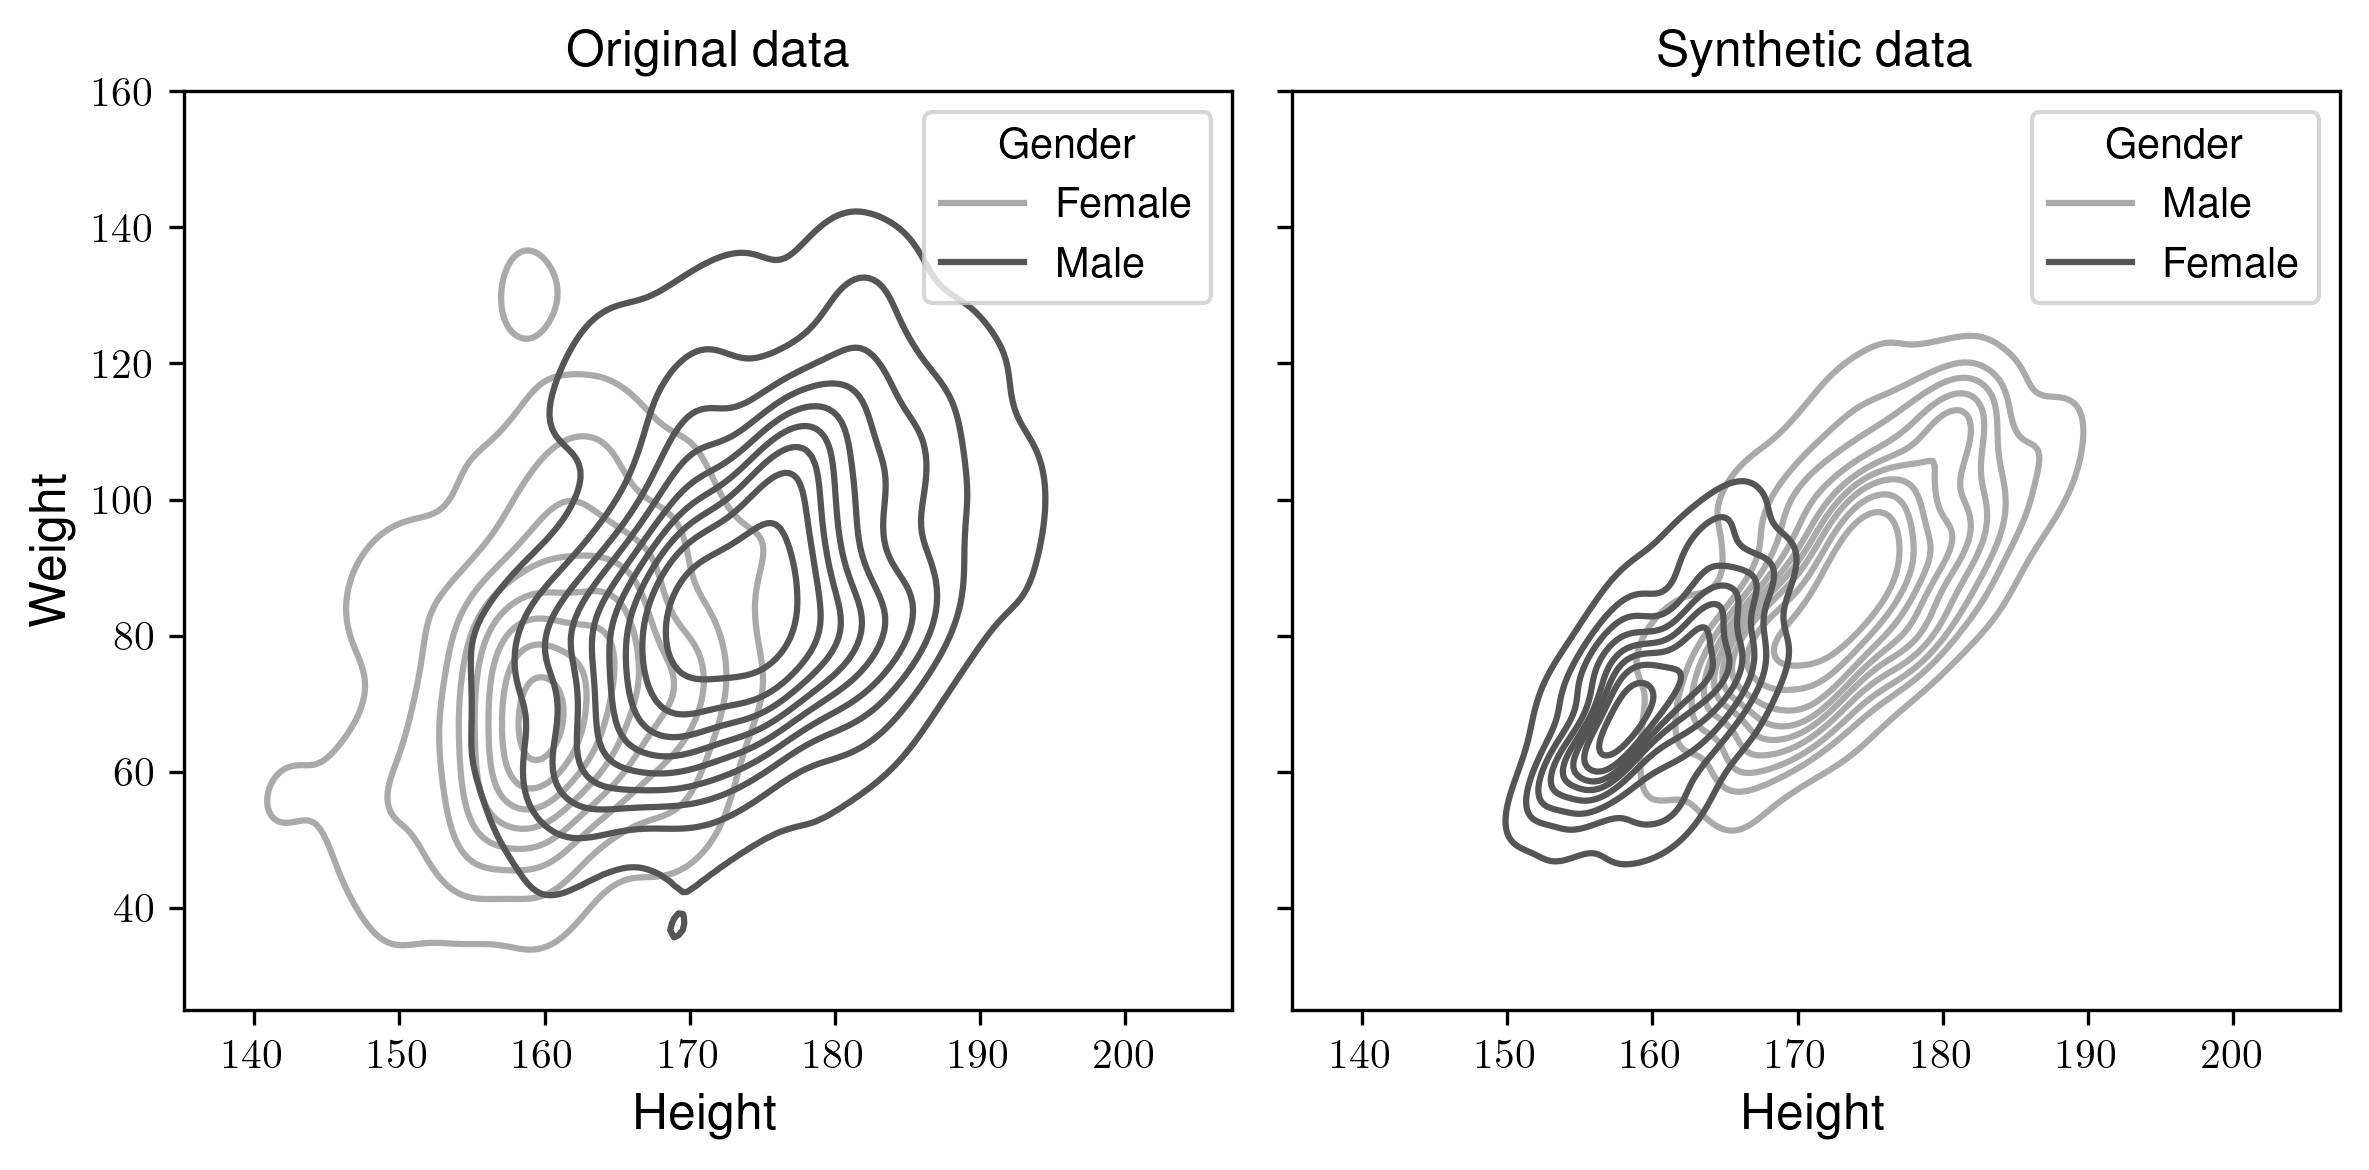

In [38]:
cmaps = ['binary', 'YlOrBr']
palette = cmaps[0]

colX, colY, hue = 'Height', 'Weight', 'Gender'
fig, ax = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
sns.kdeplot(data=df_dataset, x=colX, y=colY, hue=hue, palette=palette, ax=ax[0]);
ax[0].set_title('Original data', fontsize=12)
ax[0].set_xlabel(colX, fontsize=12)
ax[0].set_ylabel(colY, fontsize=12)
ax[0].set_ylim([25, 160])
sns.kdeplot(data=df_synthetic, x=colX, y=colY, hue=hue, palette=palette);
ax[1].set_title('Synthetic data', fontsize=12)
ax[1].set_xlabel(colX, fontsize=12)
ax[1].set_ylabel(colY, fontsize=12)
plt.tight_layout()
plt.savefig(
    f'images/4_Gender_dist_mysol.png',
    dpi=300,
    bbox_inches = 'tight',
)
plt.show()

C:\Users\jaroslawdrapala\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaroslawdrapala\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaroslawdrapala\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaroslawdrapala\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

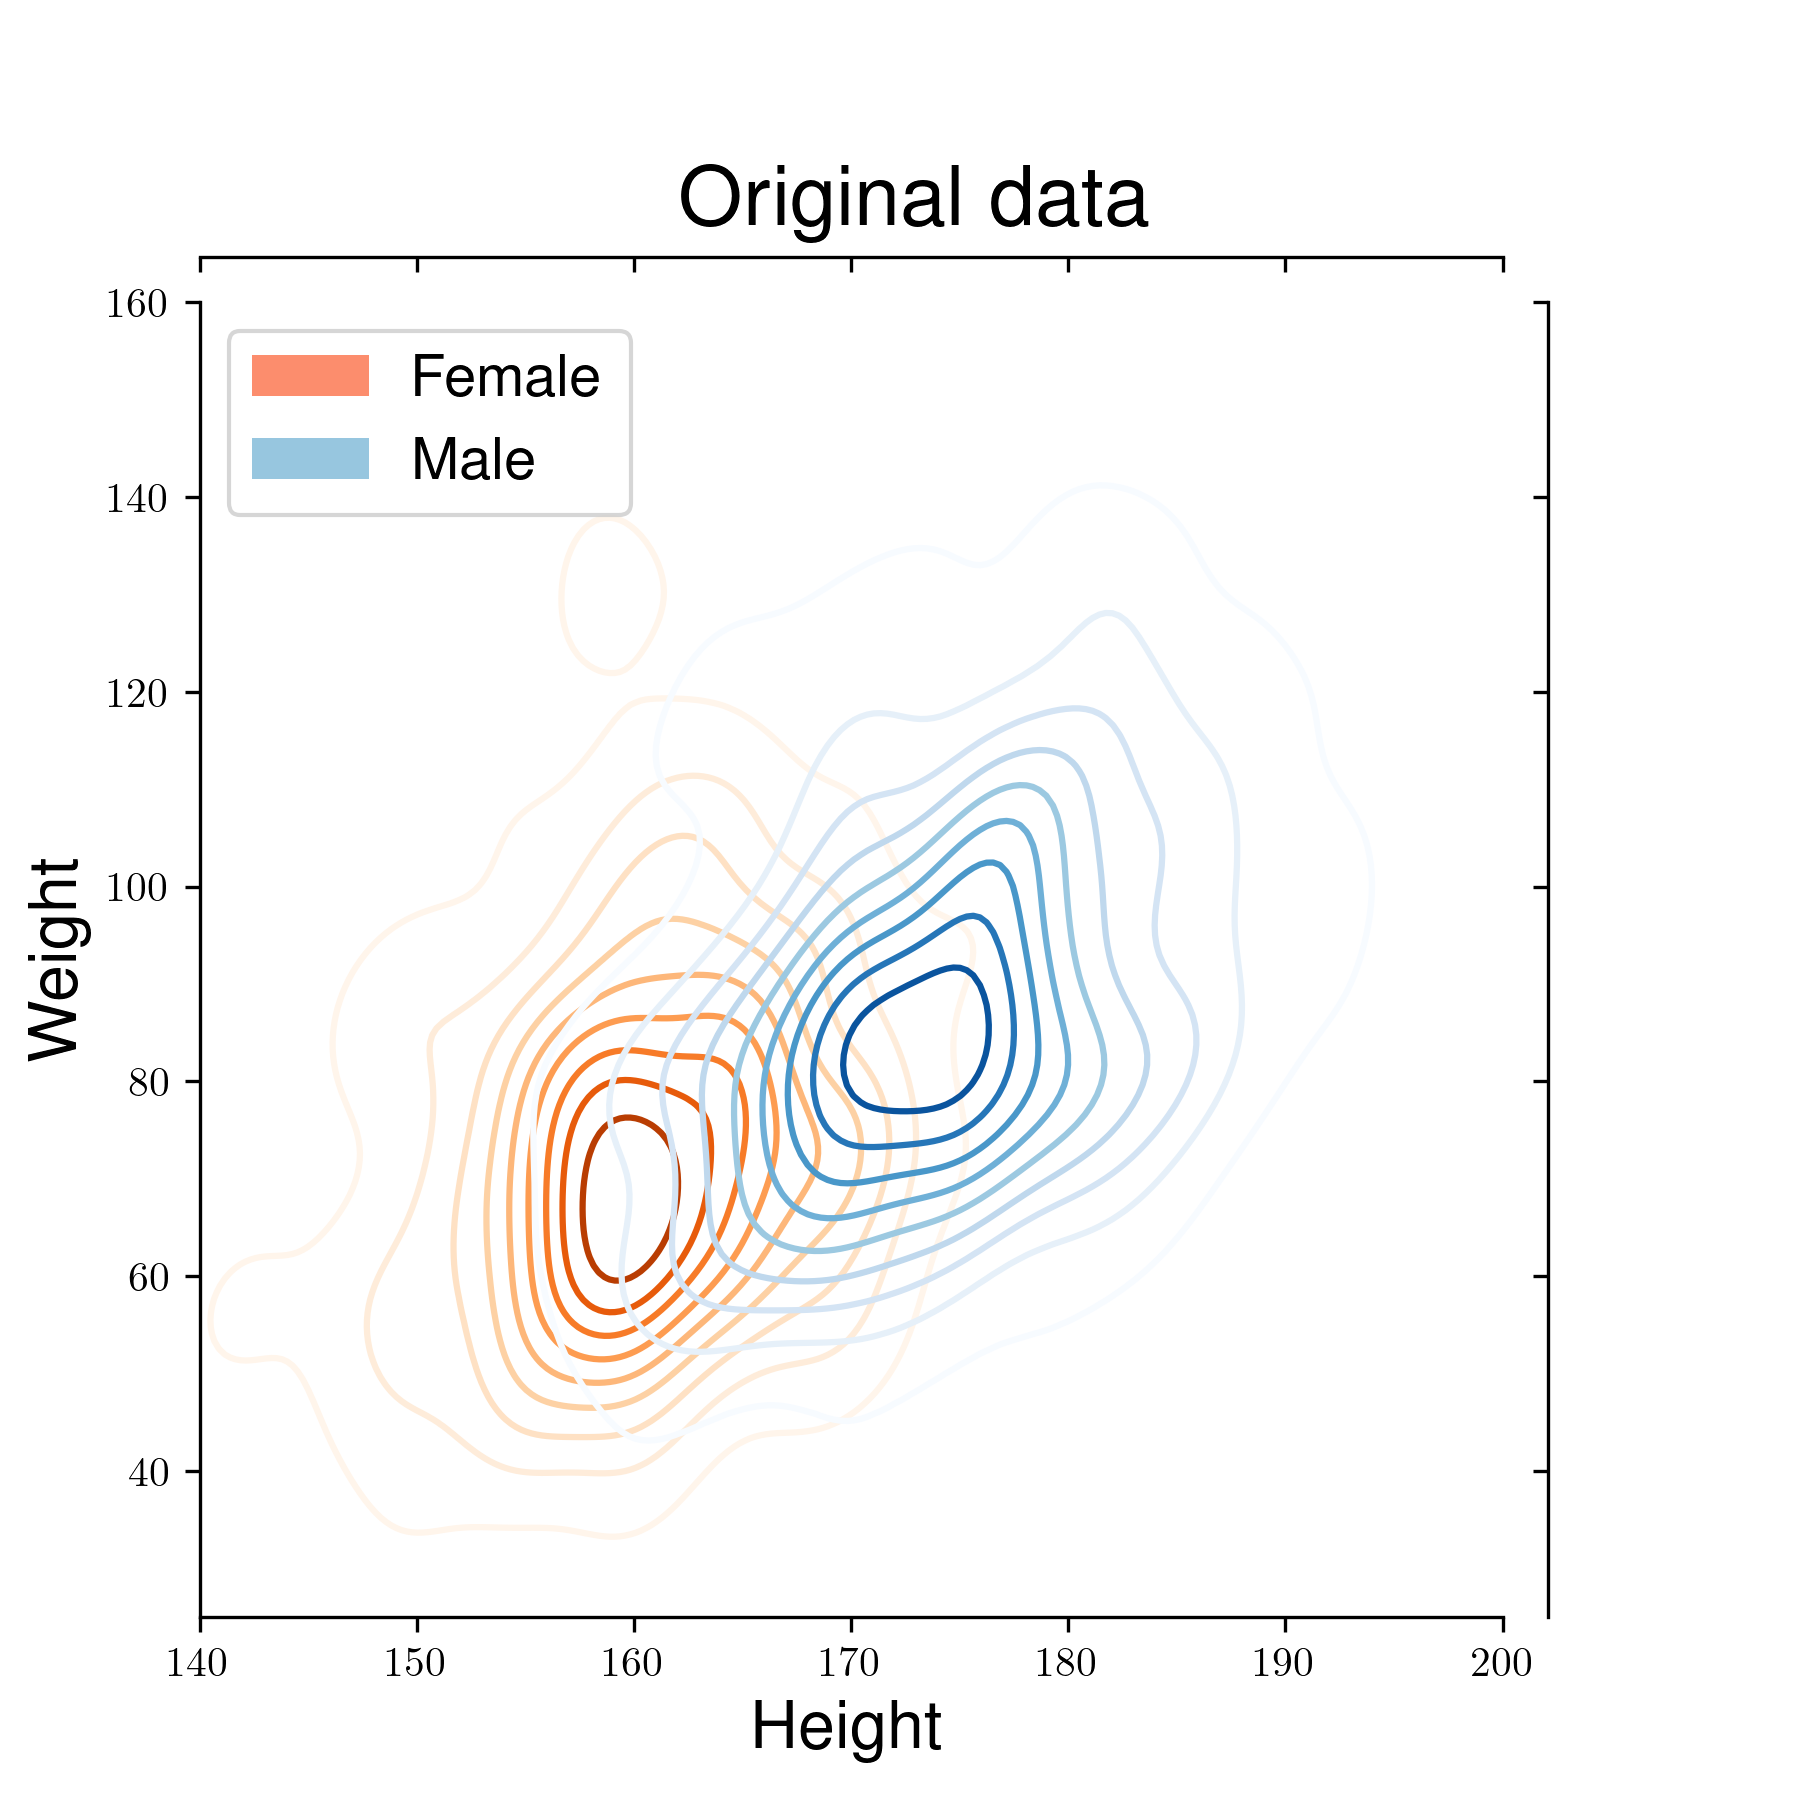

C:\Users\jaroslawdrapala\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaroslawdrapala\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaroslawdrapala\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaroslawdrapala\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

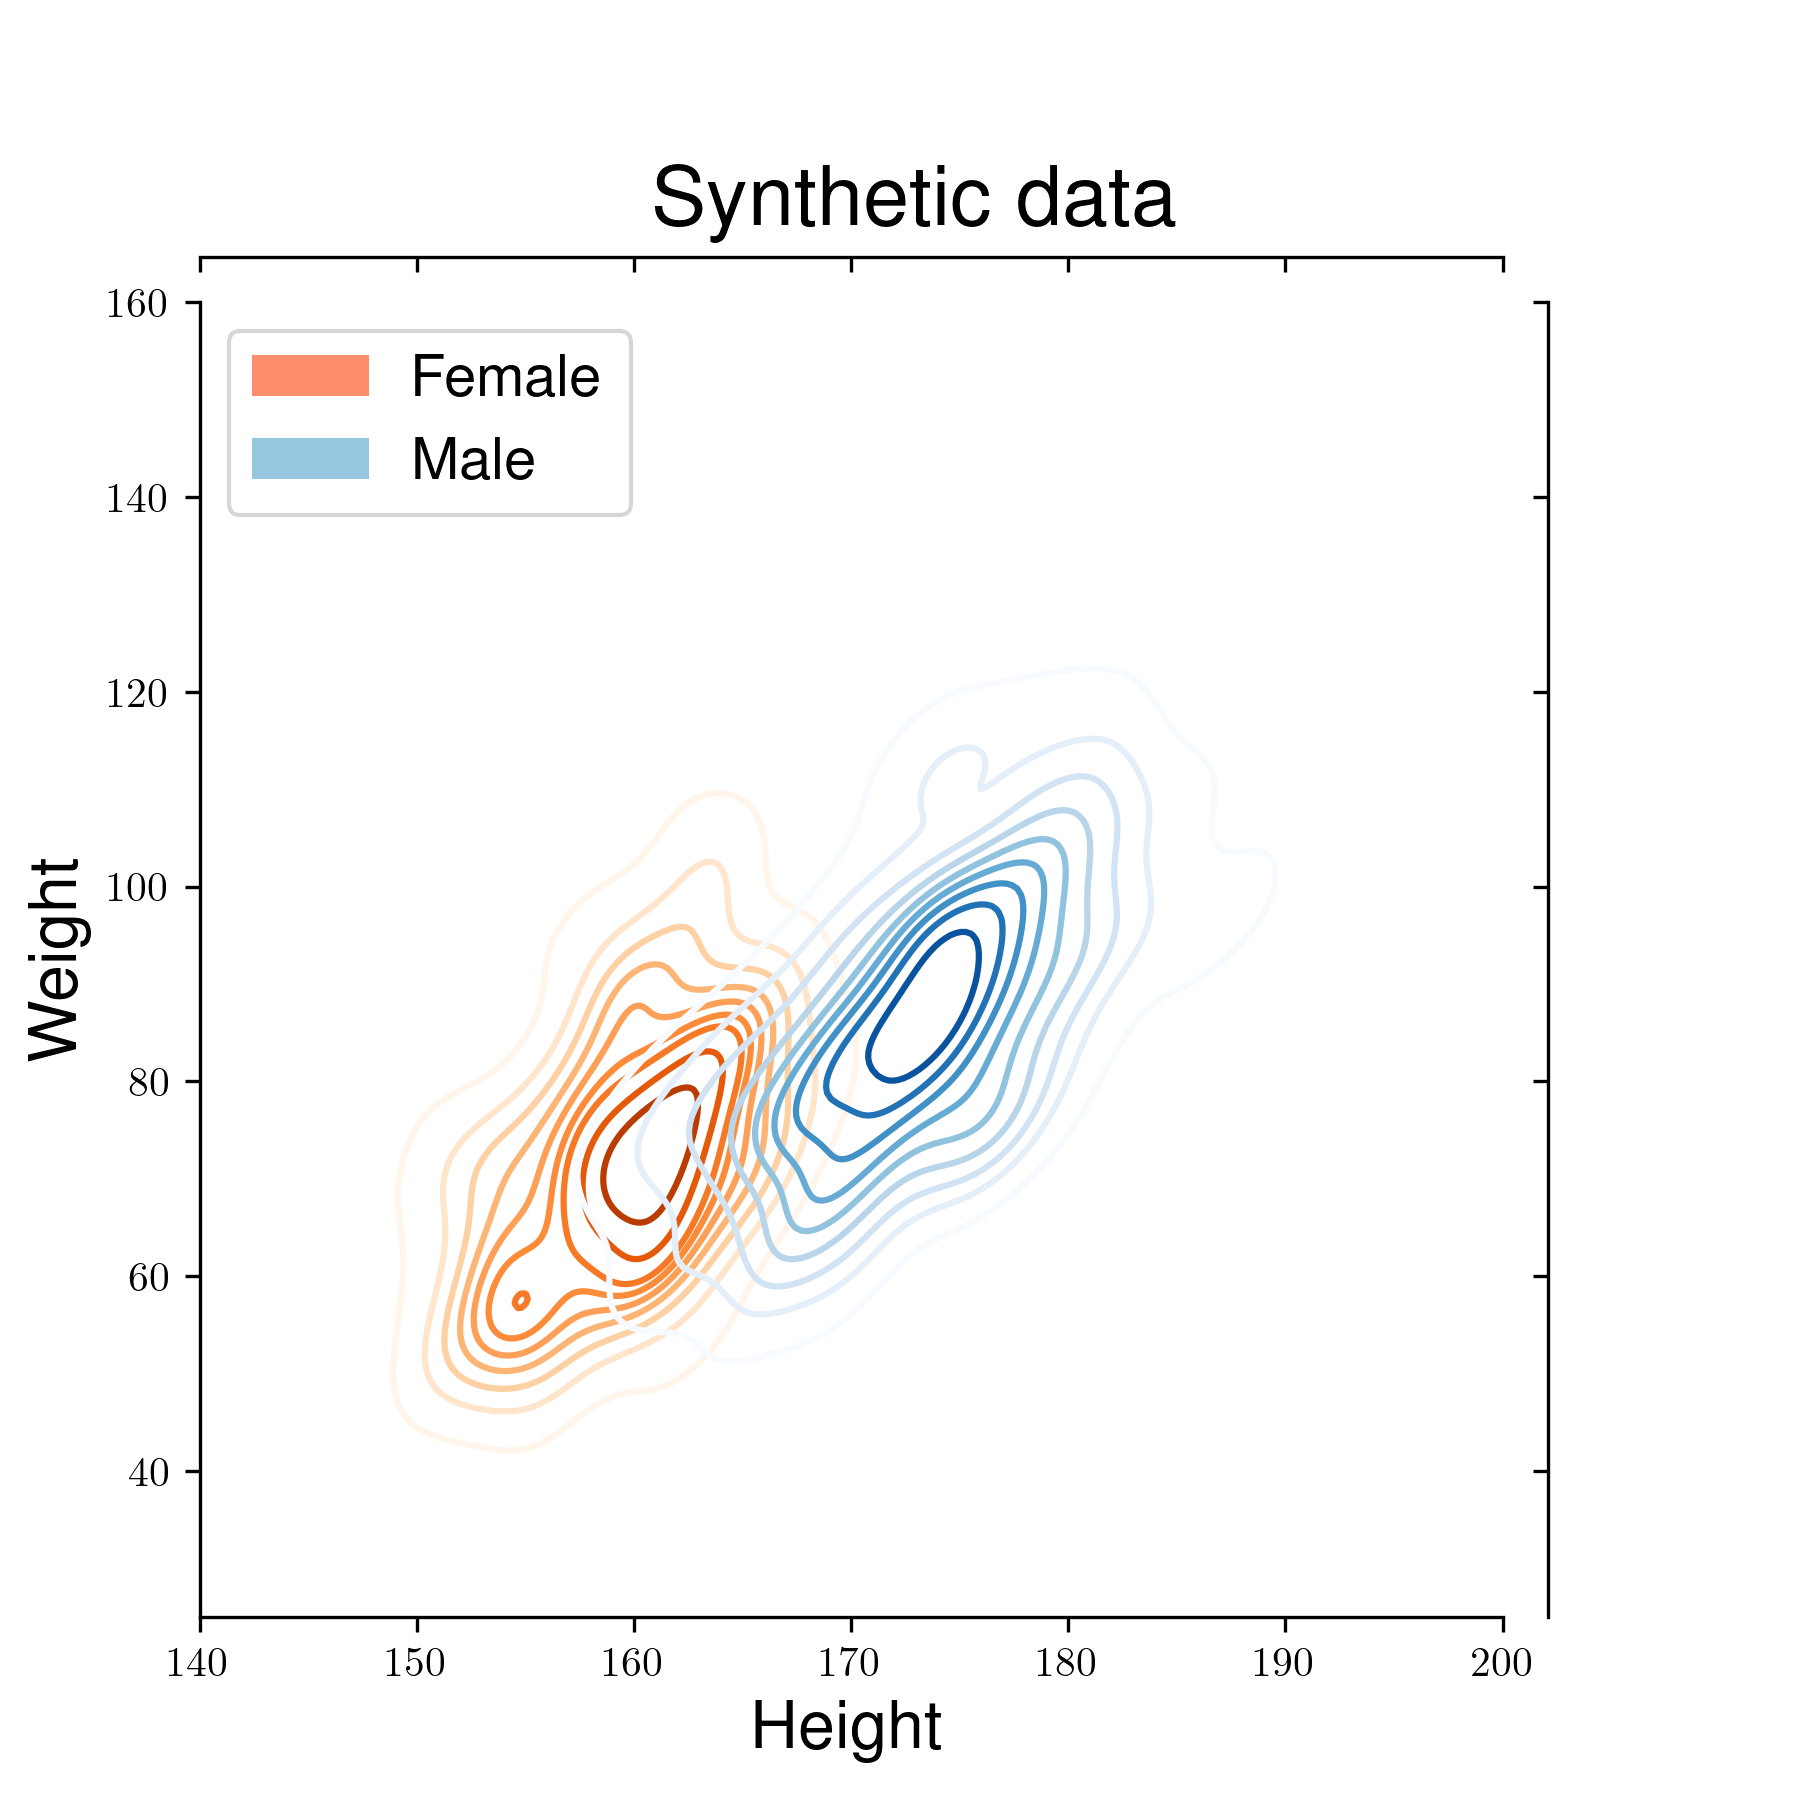

In [16]:
import matplotlib.patches as mpatches

colX, colY, hue = 'Height', 'Weight', 'Gender'
g = sns.JointGrid(x=colX, y=colY, data=df_dataset)
w=sns.kdeplot(data=df_dataset[df_dataset[hue] == 'Female'], x=colX, y=colY,
            label='Female',
            #palette=['tab:orange', 'tab:blue'],
            cmap="Oranges",
            ax=g.ax_joint
           );
sns.kdeplot(data=df_dataset[df_dataset[hue] == 'Male'], x=colX, y=colY,
            label='Male',
            #palette=['tab:orange', 'tab:blue'],
            cmap="Blues",
            ax=g.ax_joint
           );
handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="Female"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="Male")]
plt.legend(handles=handles, loc="upper left", bbox_to_anchor=([-6,1]), fontsize=14)
w.set_xlabel(colX, fontsize=16)
w.set_ylabel(colY, fontsize=16)
w.set_xlim([140, 200])
w.set_ylim([25, 160])
g.fig.suptitle("Original data", y=0.9, fontsize=20)
plt.savefig(
    f'images/4a_Gender_dist_mysol.png',
    dpi=300,
    bbox_inches = 'tight'
)
plt.show()



colX, colY, hue = 'Height', 'Weight', 'Gender'
g = sns.JointGrid(x=colX, y=colY, data=df_dataset)
w=sns.kdeplot(data=df_synthetic[df_synthetic[hue] == 'Female'], x=colX, y=colY,
            label='Female',
            #palette=['tab:orange', 'tab:blue'],
            cmap="Oranges",
            ax=g.ax_joint
           );
sns.kdeplot(data=df_synthetic[df_synthetic[hue] == 'Male'], x=colX, y=colY,
            label='Male',
            #palette=['tab:orange', 'tab:blue'],
            cmap="Blues",
            ax=g.ax_joint
           );
handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="Female"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="Male")]
plt.legend(handles=handles, loc="upper left", bbox_to_anchor=([-6,1]), fontsize=14)
w.set_xlabel(colX, fontsize=16)
w.set_ylabel(colY, fontsize=16)
w.set_xlim([140, 200])
w.set_ylim([25, 160])
g.fig.suptitle("Synthetic data", y=0.9, fontsize=20)
plt.savefig(
    f'images/4b_Gender_dist_mysol.png',
    dpi=300,
    bbox_inches = 'tight'
)
plt.show()

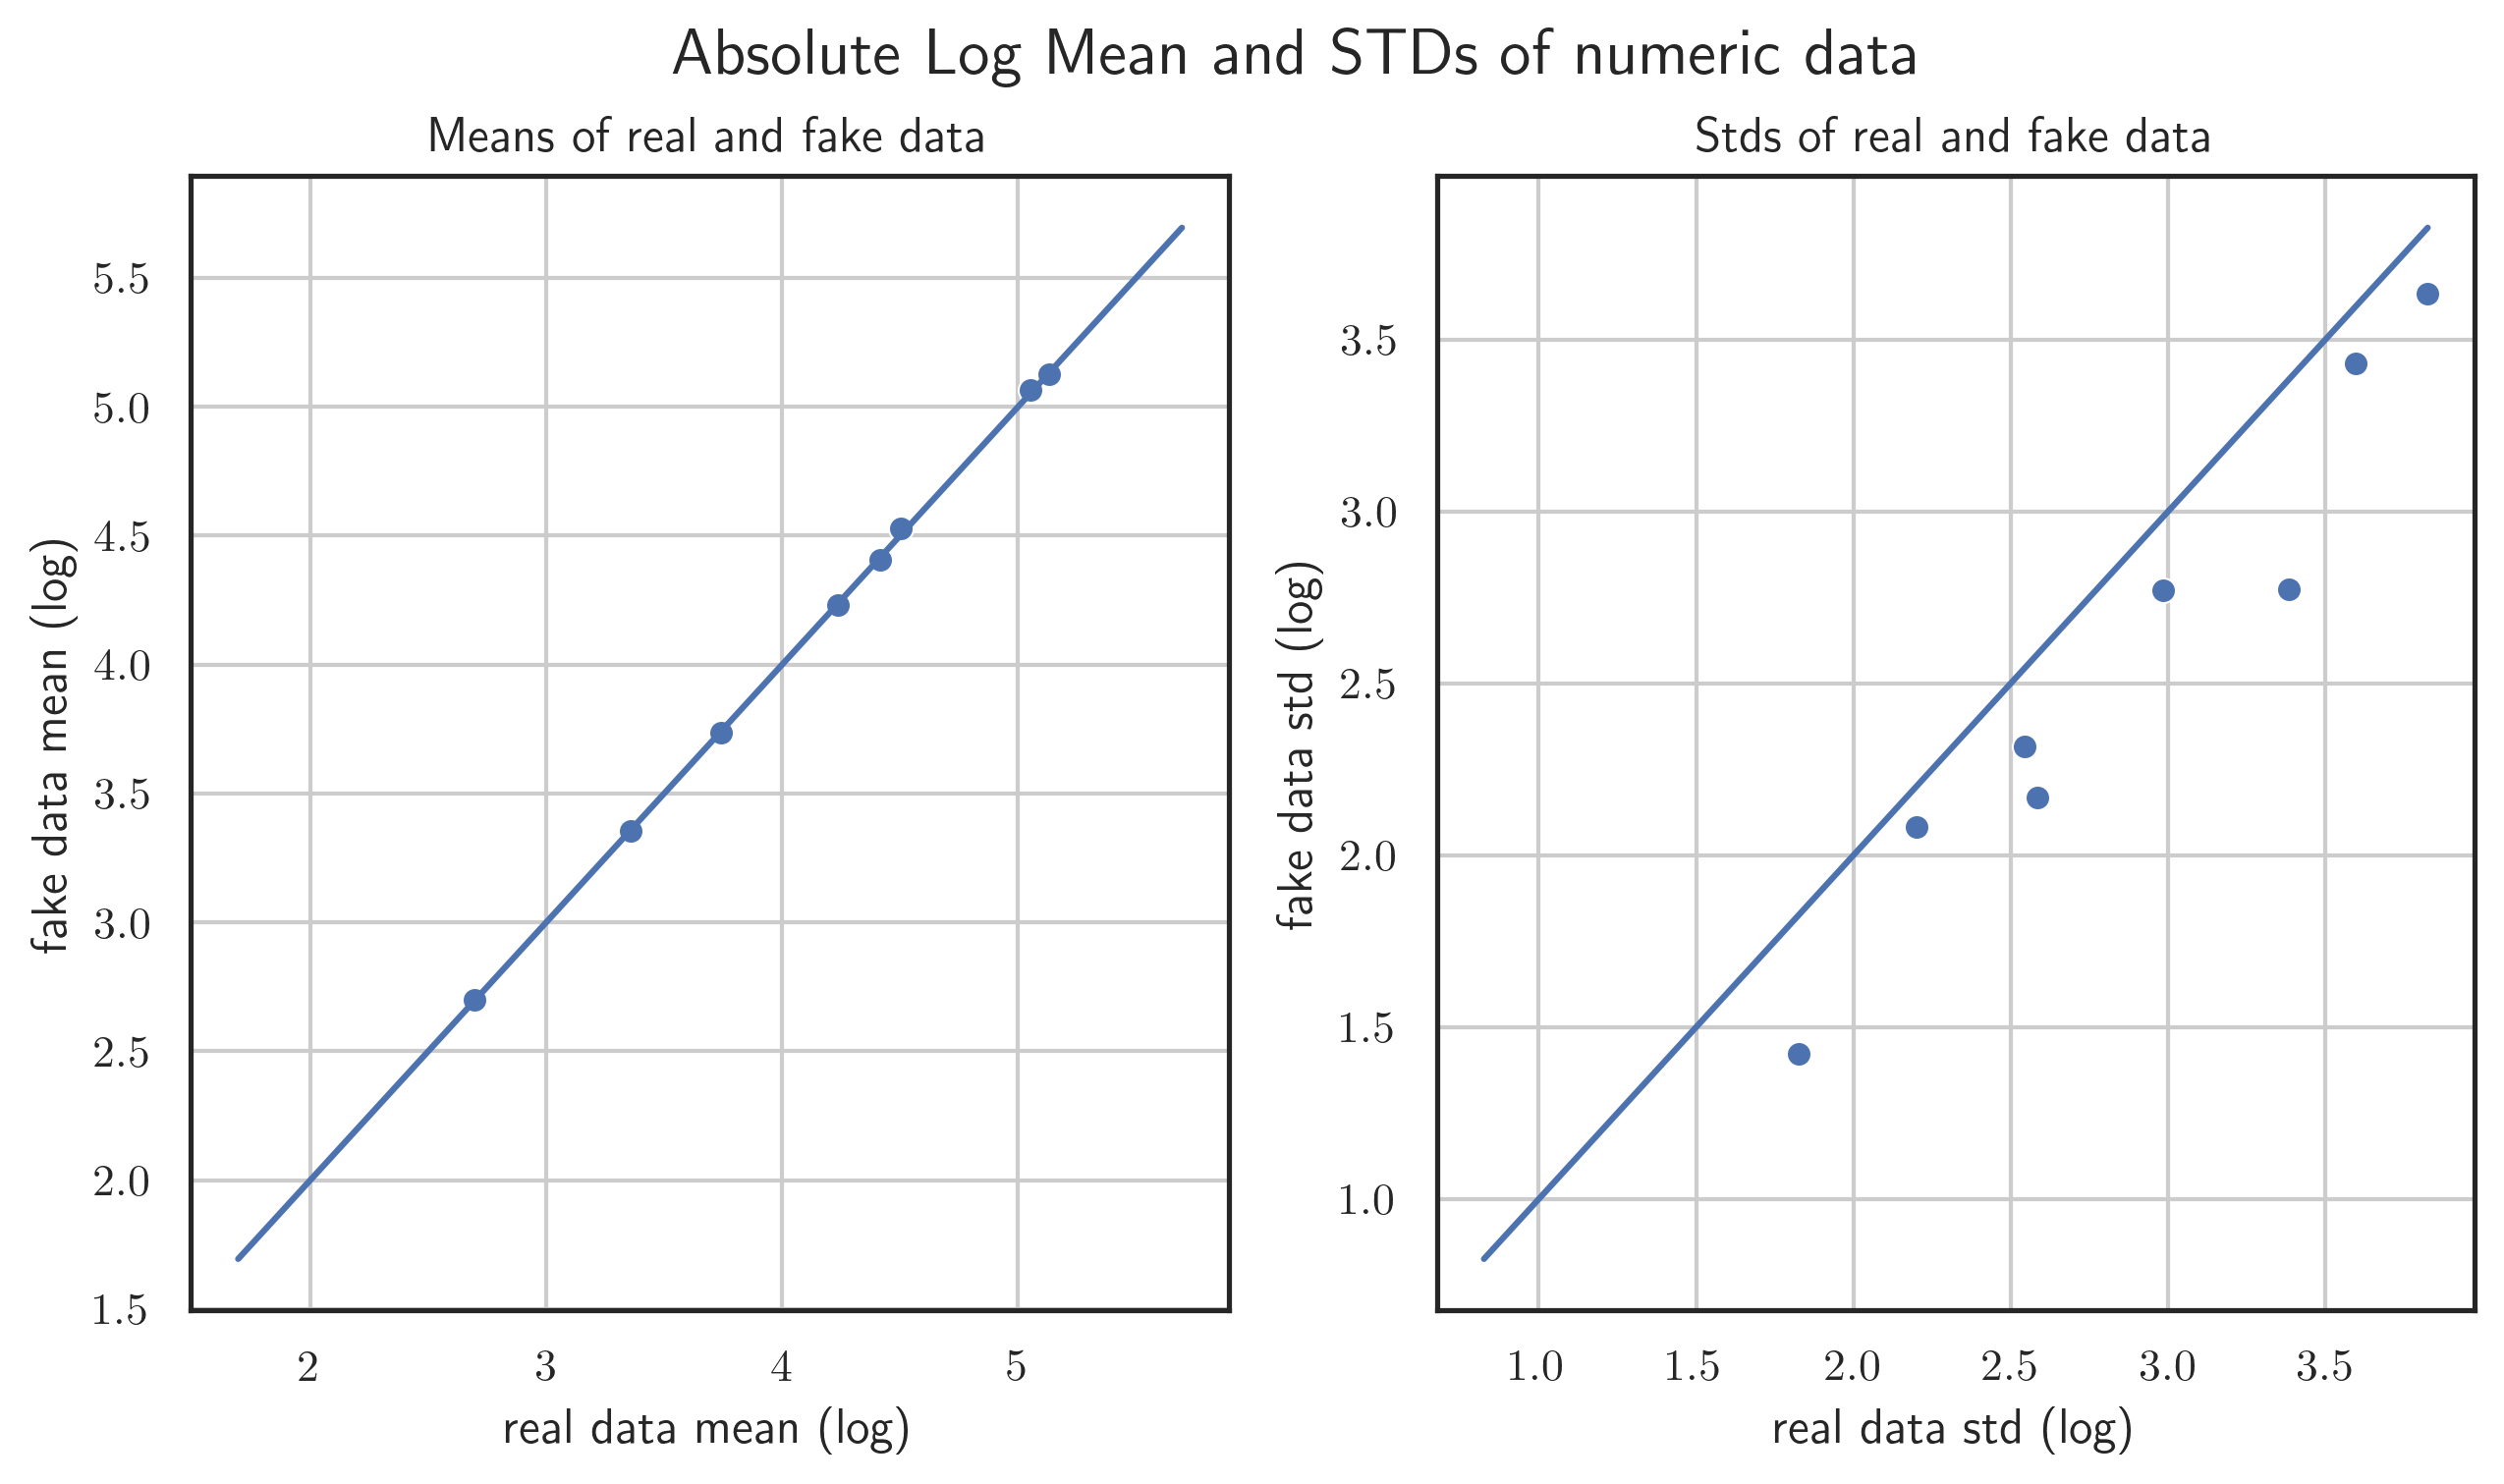

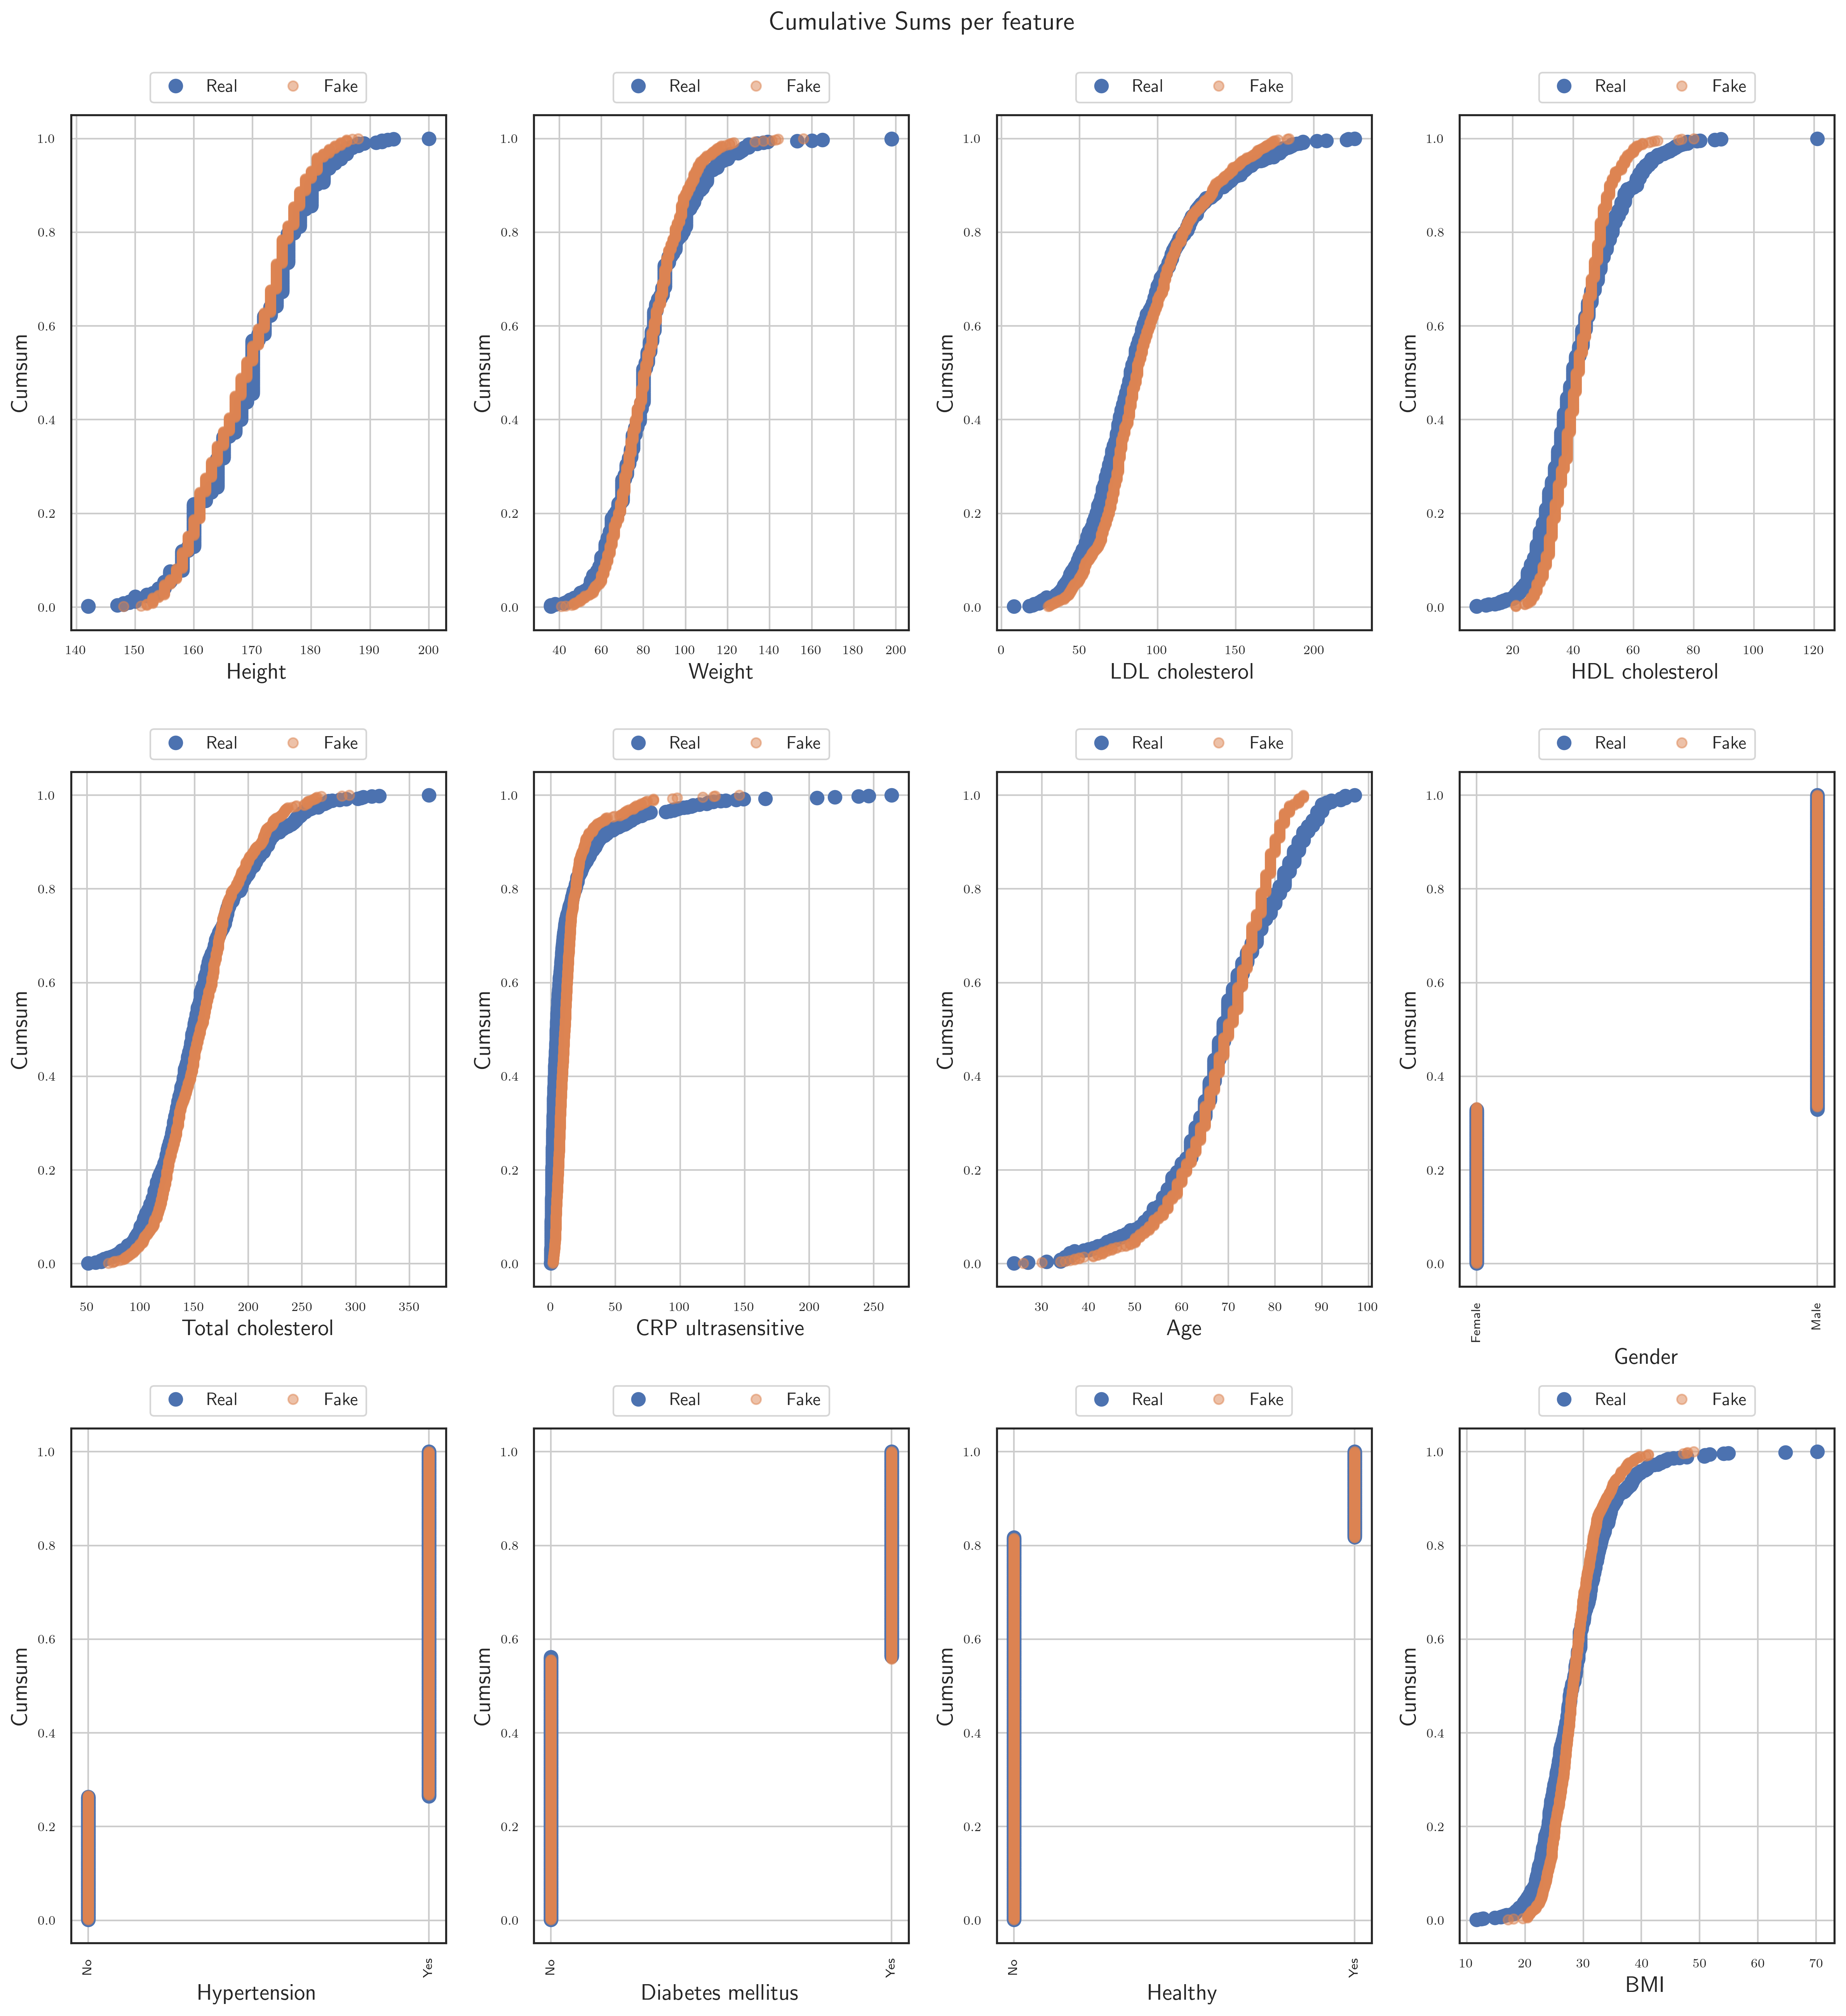

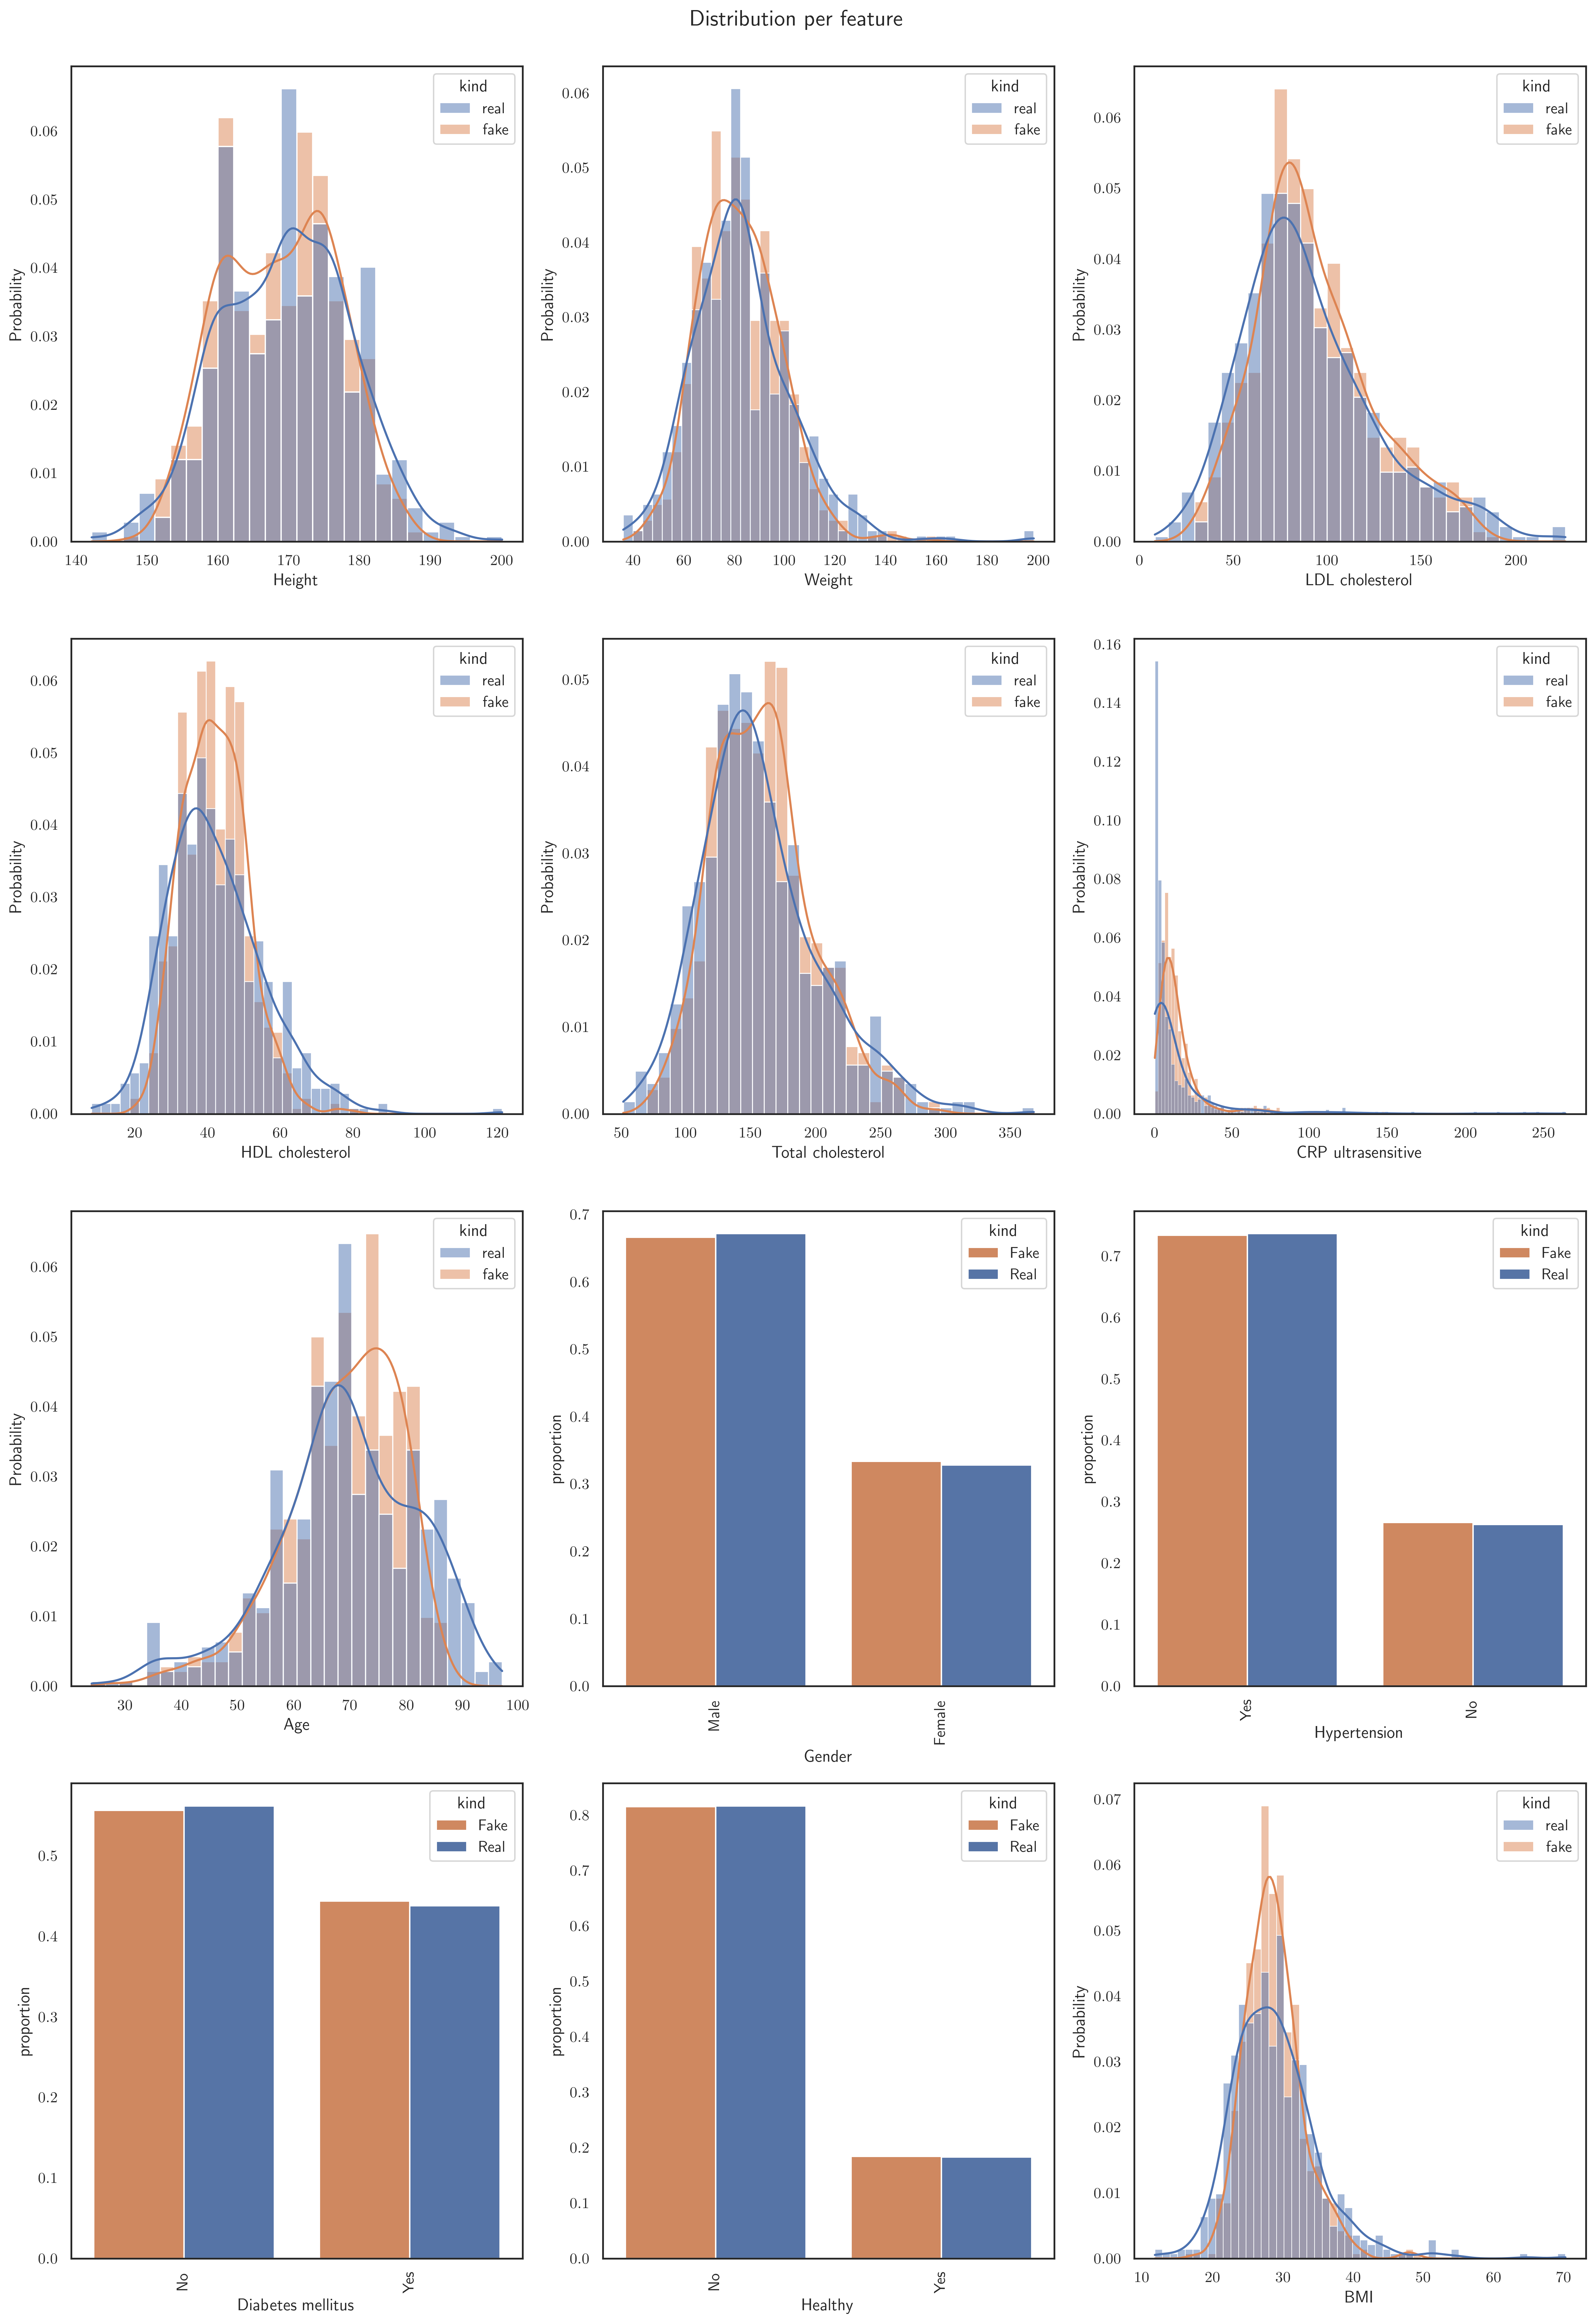

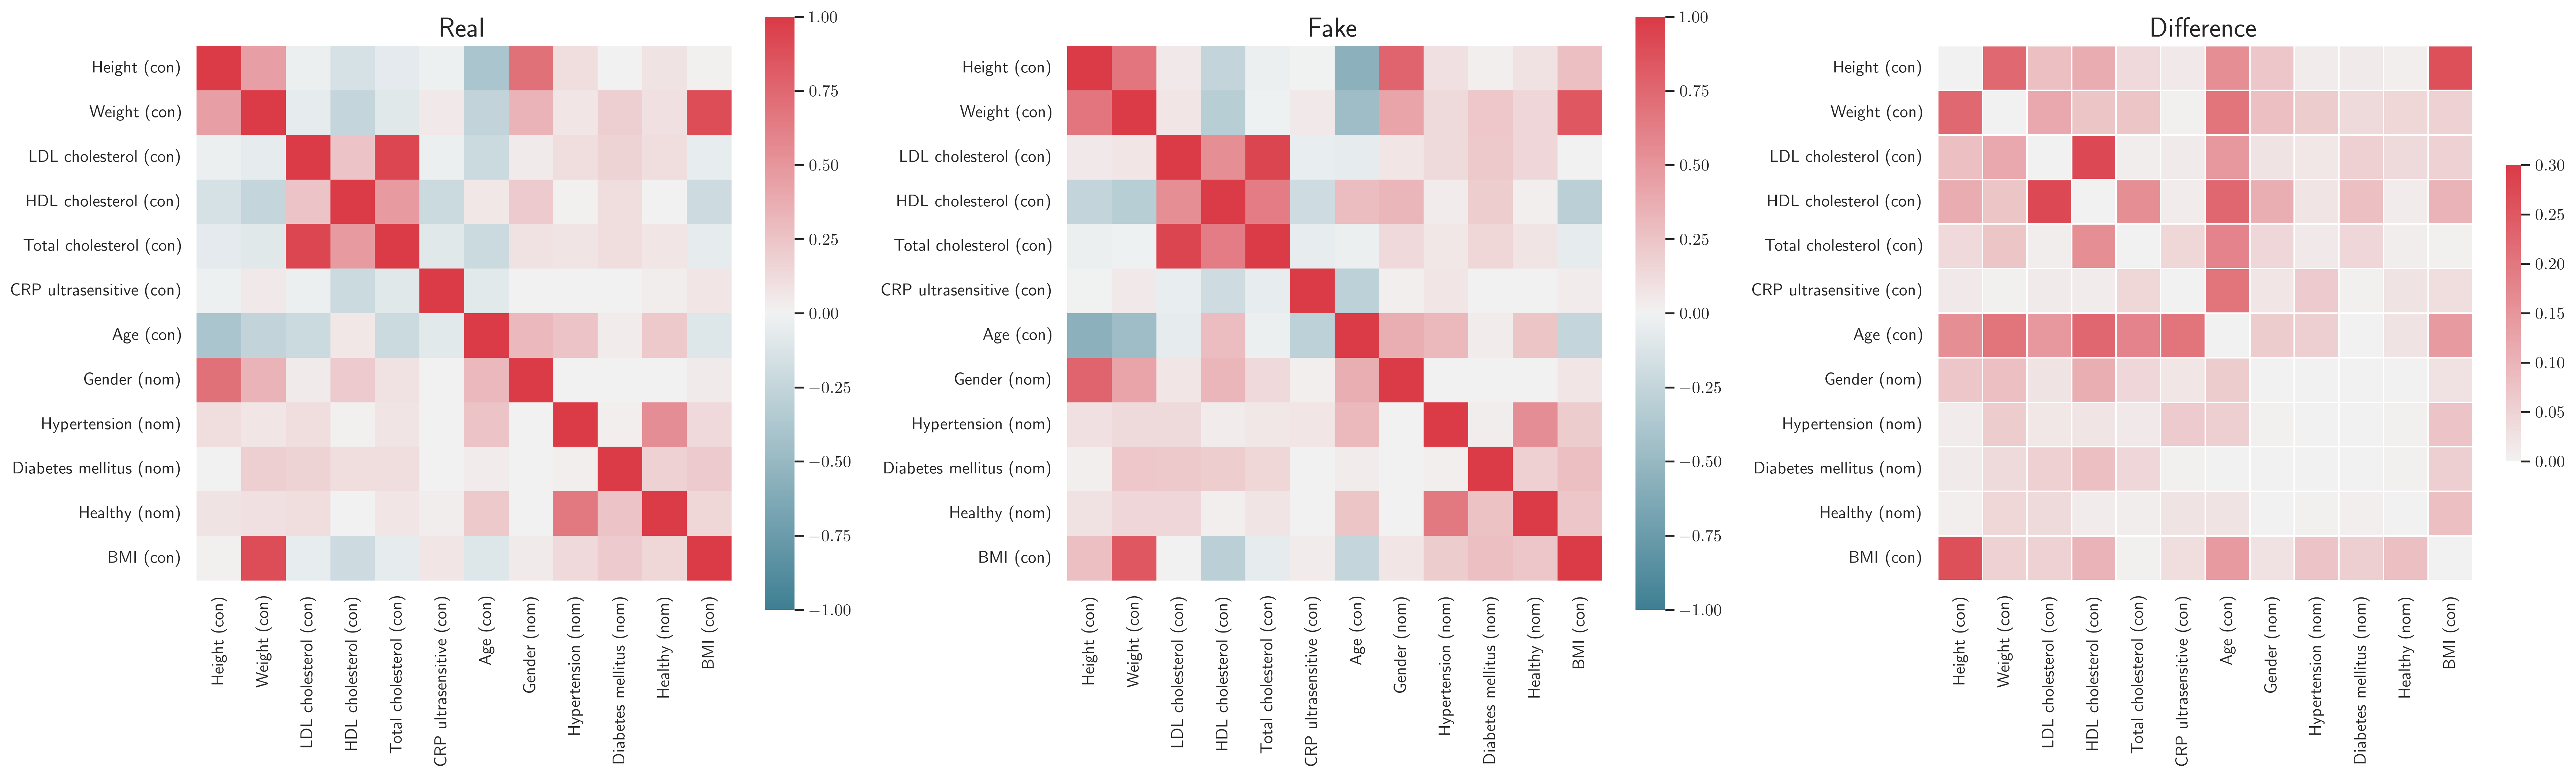

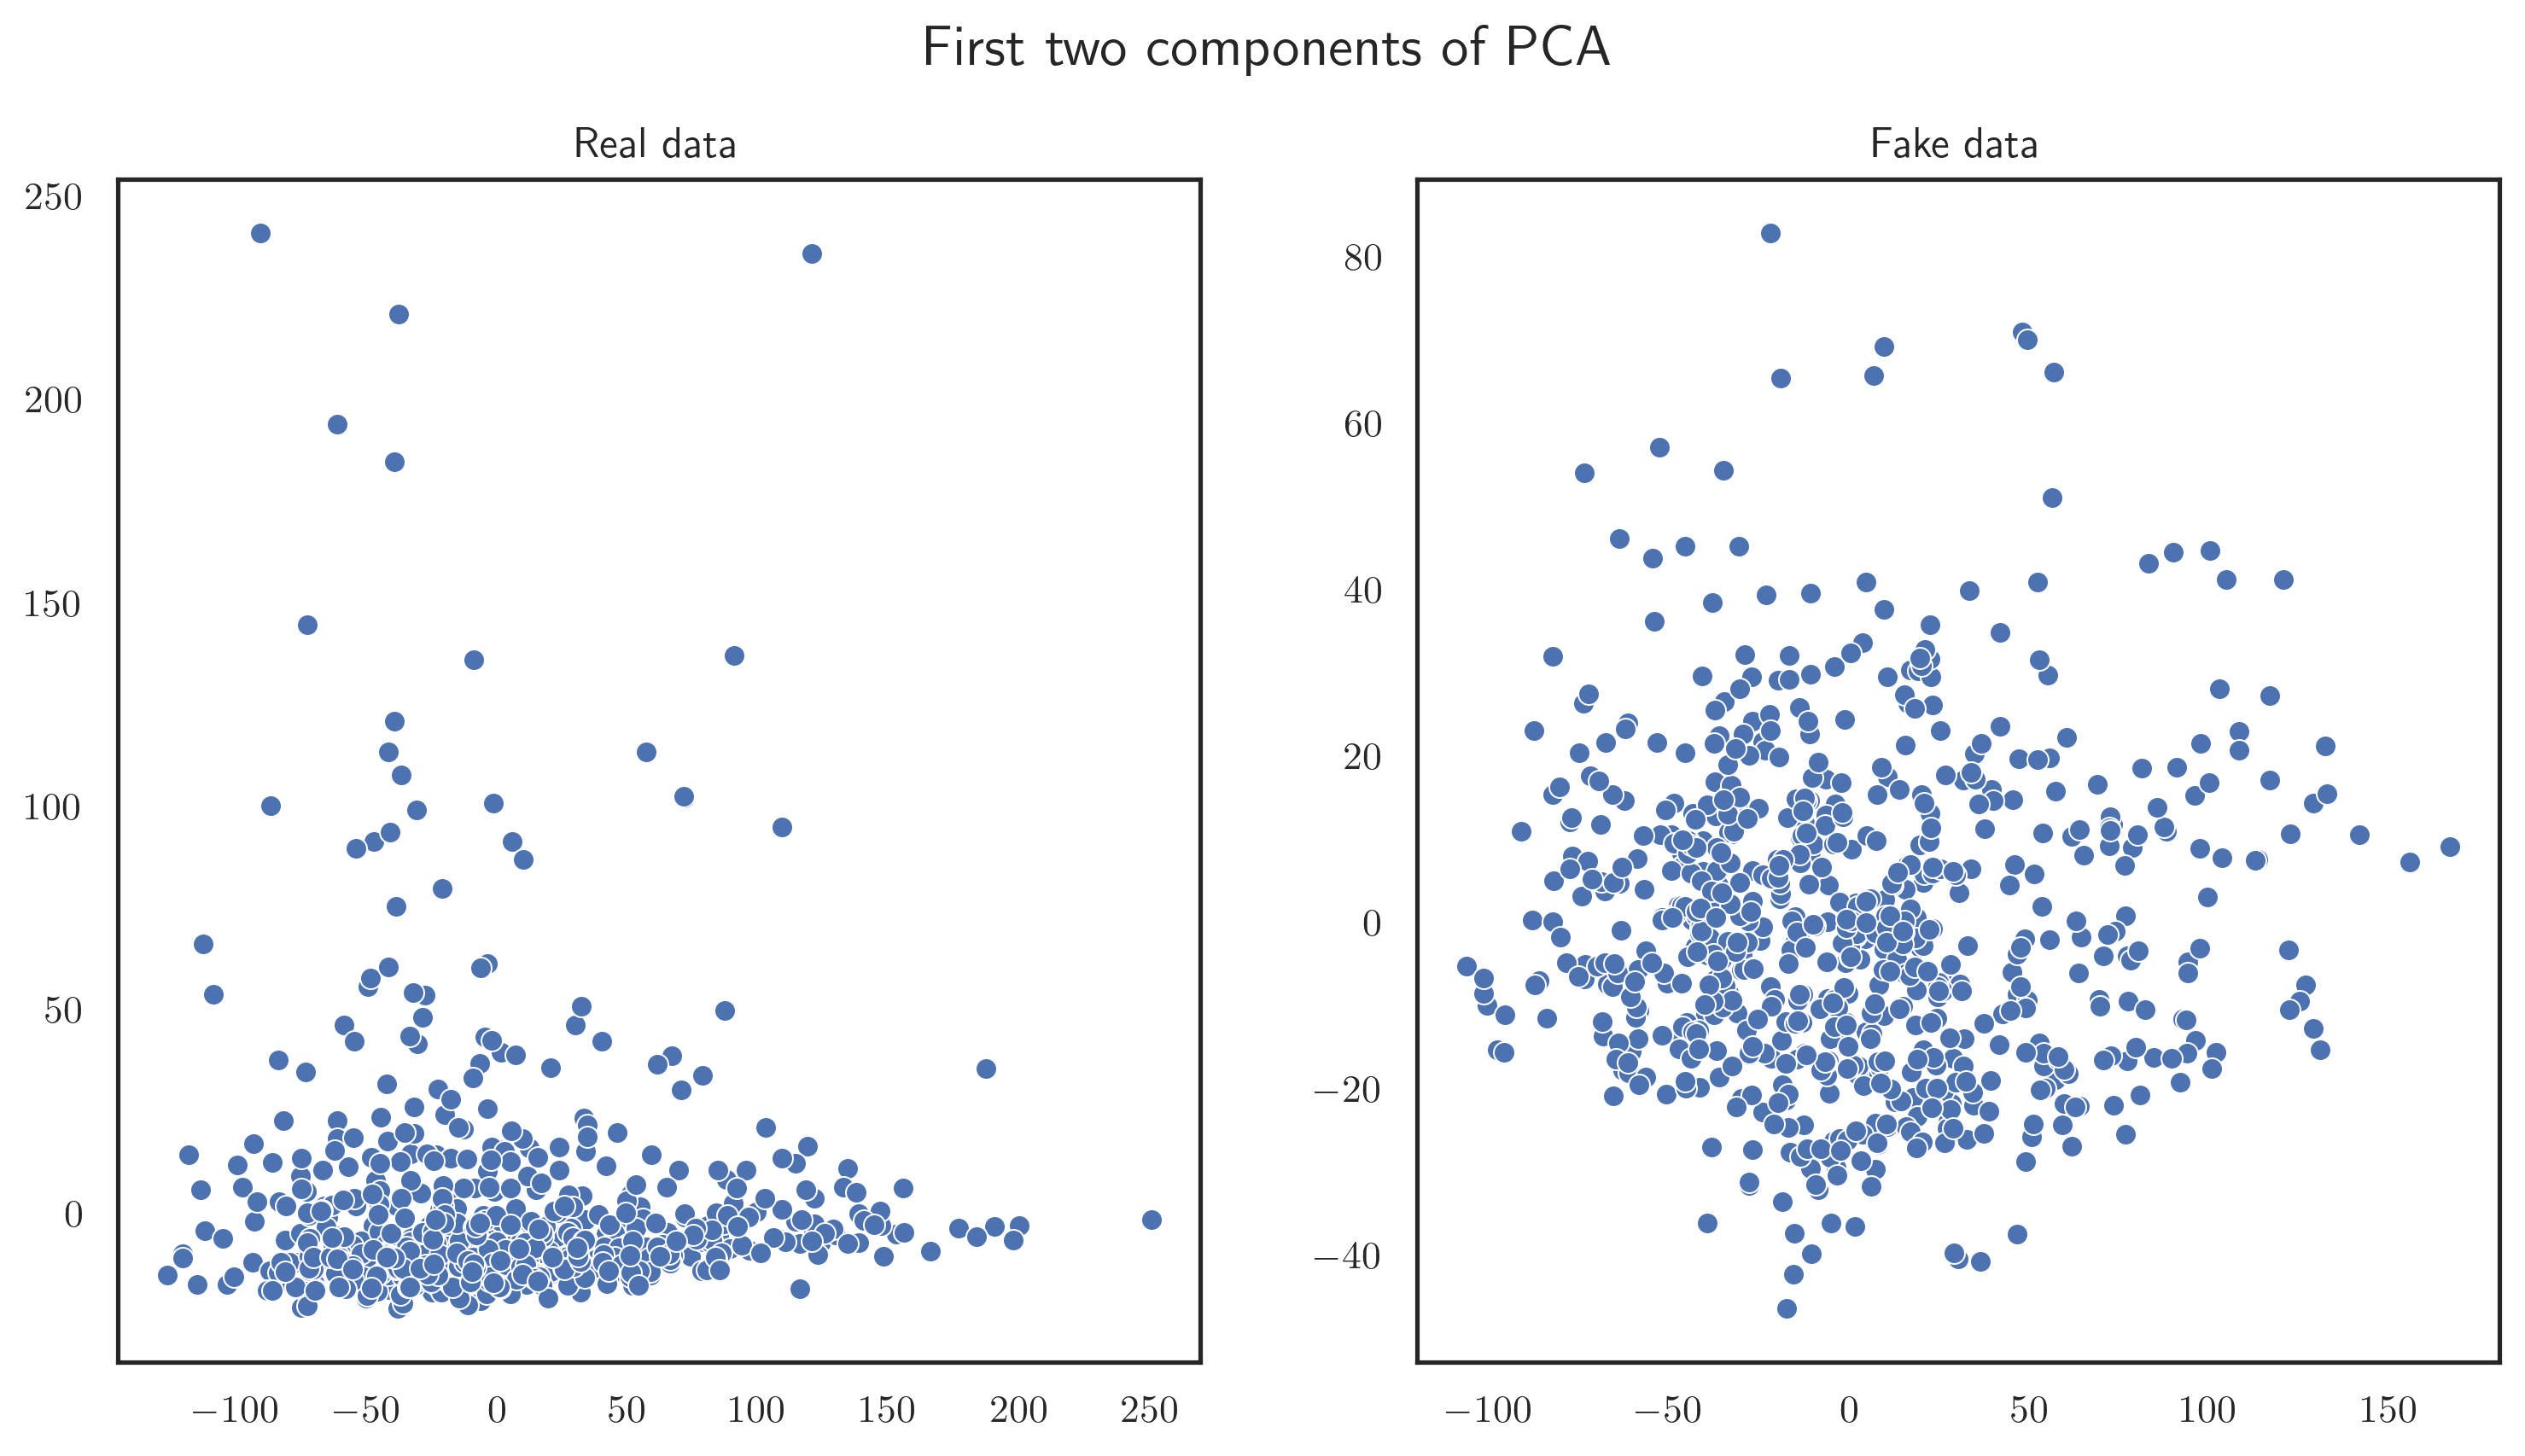

In [21]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(df_dataset, df_synthetic)
table_evaluator.visual_evaluation()

### Correctness of generating BMI values

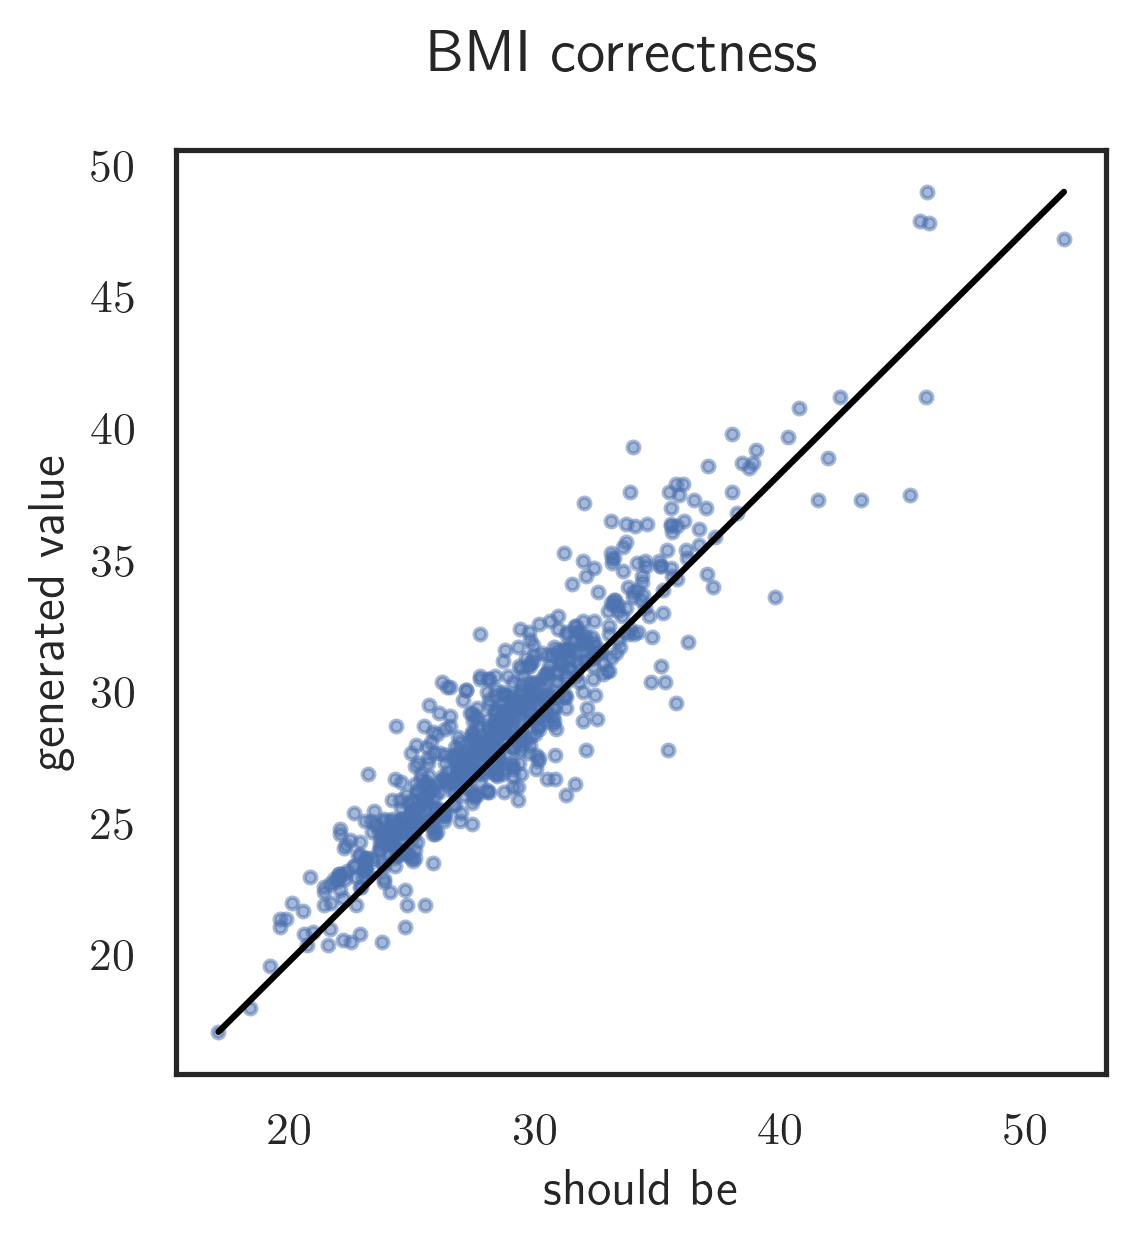

In [20]:
df_BMI_should_be = df_synthetic['Weight'] / ((df_synthetic['Height']/100)**2)

fig, ax = plt.subplots(1,1, figsize=(4,4), sharey=True)
ax.scatter(
    df_BMI_should_be,
    df_synthetic['BMI'],
    alpha=0.5, s=8
)
ax.plot(
    [df_BMI_should_be.min(), df_BMI_should_be.max()],
    [df_synthetic['BMI'].min(), df_synthetic['BMI'].max()],
    color='black'
)
ax.set_xlabel('should be')
ax.set_ylabel('generated value')
fig.suptitle('BMI correctness')
plt.savefig(
    f'images/8_BMI_valid_mysol.png',
    dpi=300,
    facecolor='white',
    bbox_inches = 'tight',
)
plt.show()

### Correctness of generating *Healthy* values

In [19]:
print(f"Correctness of generating Healthy values: \
{int(100 * sum(add_Healthy_column(df_synthetic[['Hypertension', 'Diabetes mellitus']])['Healthy'] == df_synthetic['Healthy']) / len(df_synthetic))} %")

Correctness of generating Healthy values: 100 %
